<a href="https://colab.research.google.com/github/MatiasHerrneder/bdm-2025/blob/main/TP01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PARTE 1


## 1 - Manejo de ruido


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# csv_file_path = '/home/signals.csv'

df = pd.read_csv('https://raw.githubusercontent.com/bdm-unlu/2025/main/TPs/TP01/signals.csv')
# df = pd.read_csv(csv_file_path)
print("Dimensiones:", df.shape)
display(df.head())

Dimensiones: (66, 5)


ID  OBS55DB  OBS60dB  OBS65dB  OTROS65dB
0   1   166400    79200     1100          0
1   2    20000    11000        0          0
2   3    37800    18000        0          0
3   4    24500    16700        0        100
4   5   103100    33500     1900        200

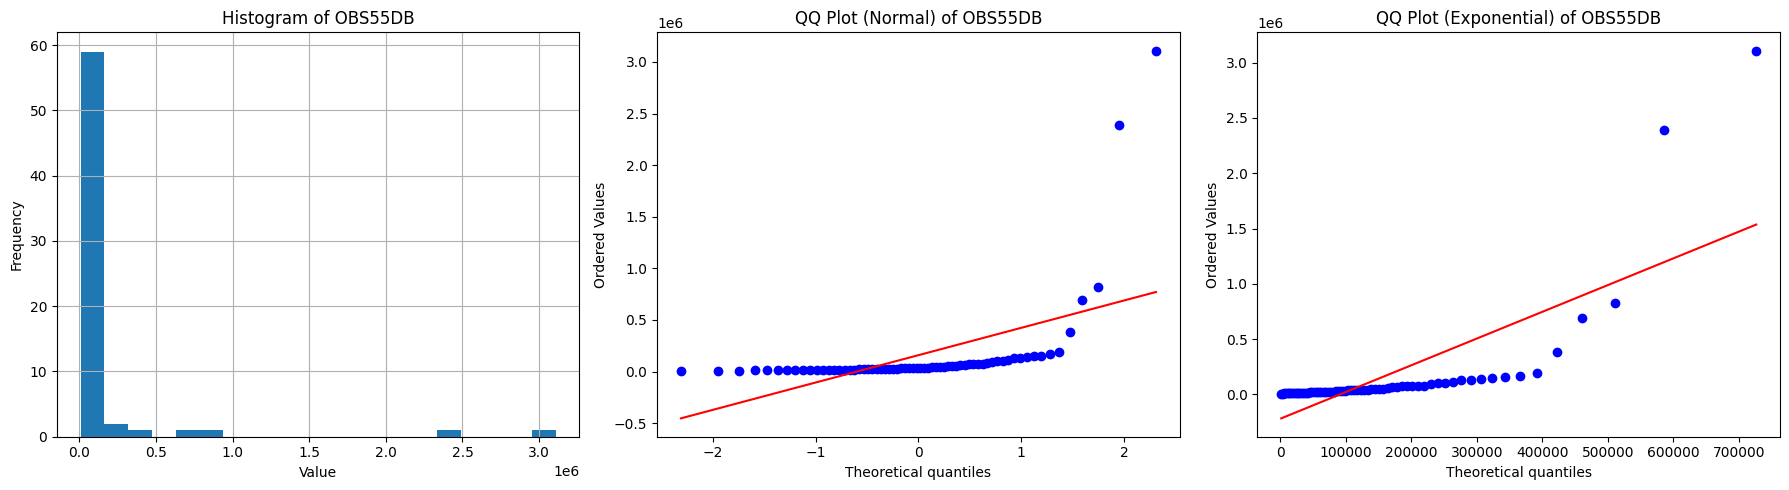

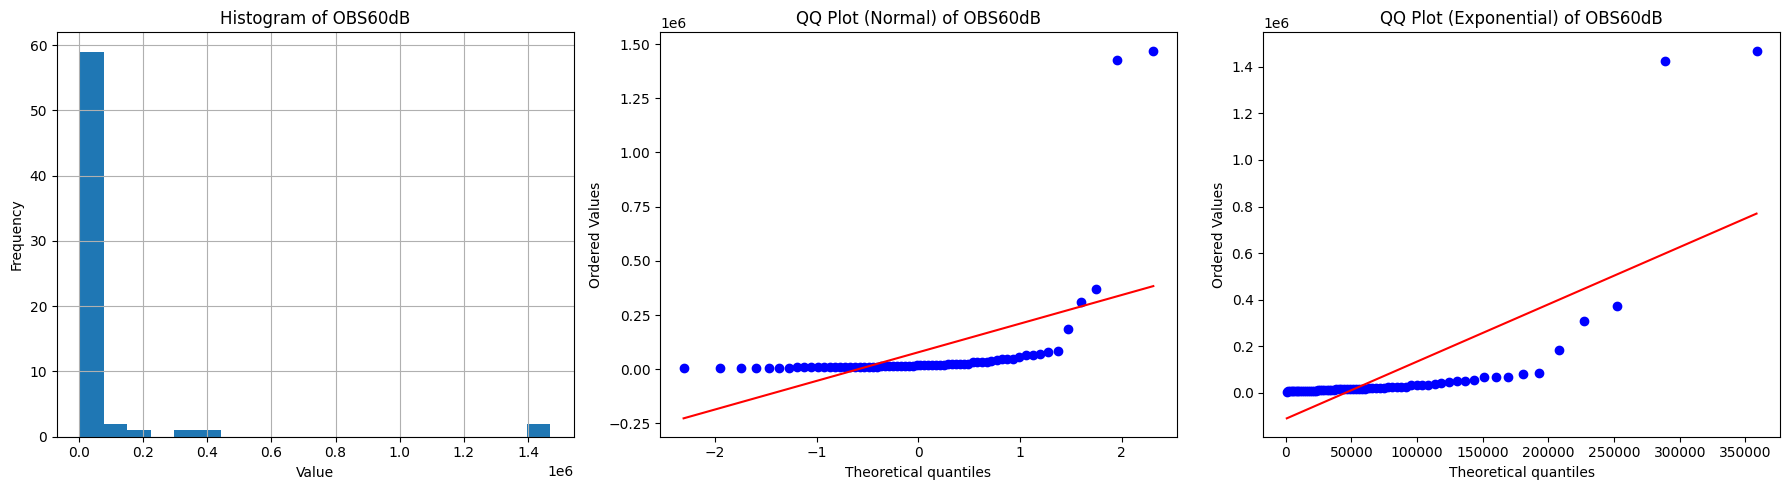

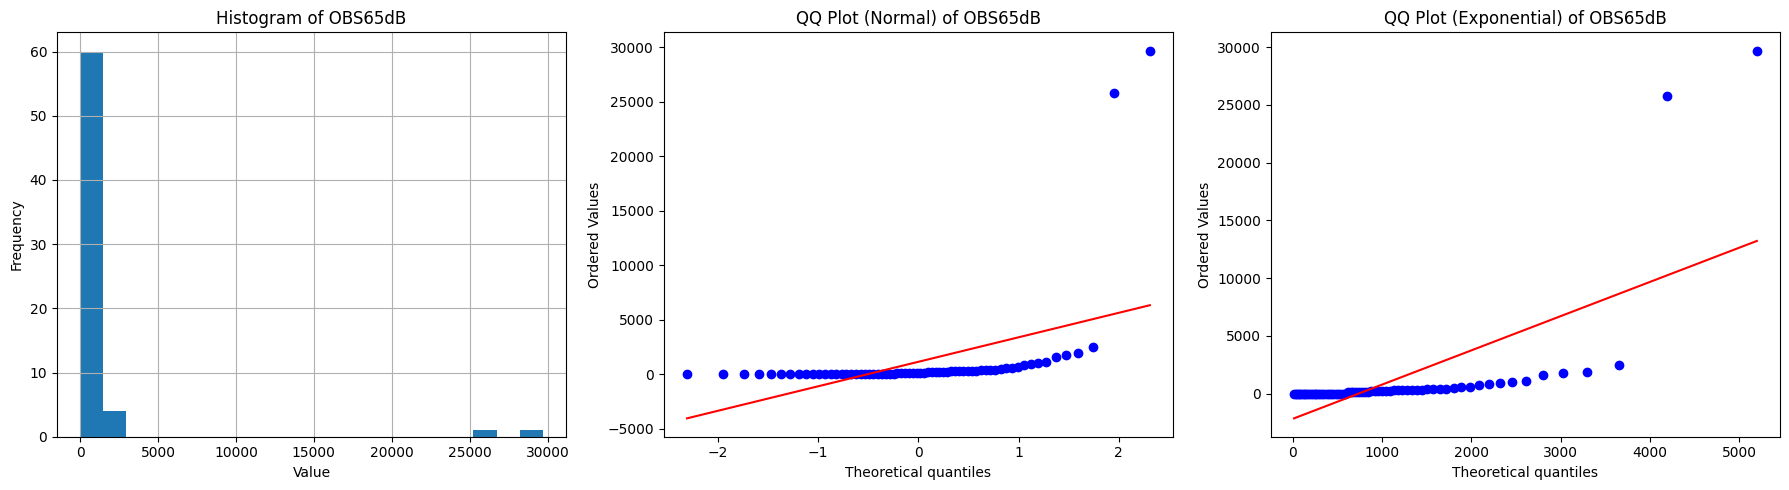

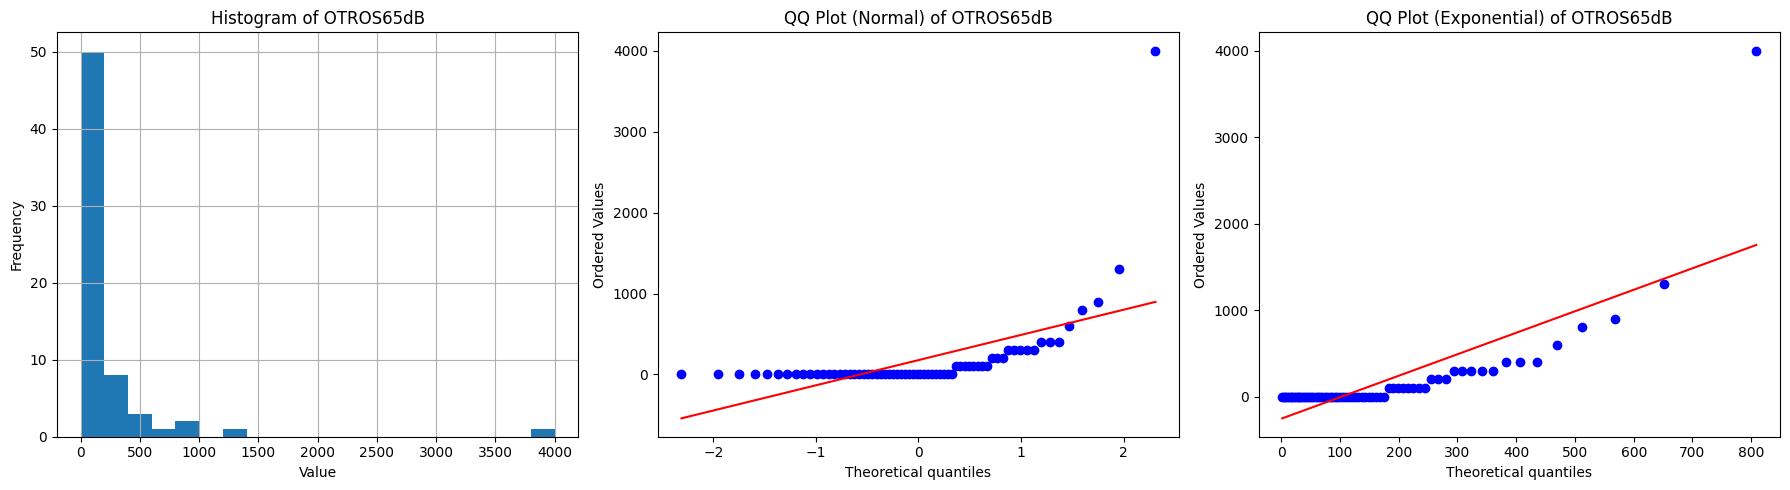

In [45]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np # Import numpy for exponential distribution

# Select the columns for analysis (excluding 'ID')
variables_to_analyze = ['OBS55DB', 'OBS60dB', 'OBS65dB', 'OTROS65dB']

# Plot histograms and QQ plots for each variable
for col in variables_to_analyze:
    plt.figure(figsize=(18, 5)) # Increase figure size to accommodate three plots

    # Histogram
    plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
    df[col].hist(bins=20)
    plt.title(f'Histogram of {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # QQ plot (Normal)
    plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(f'QQ Plot (Normal) of {col}')

    # QQ plot (Exponential)
    plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
    # Fit the exponential distribution to the data to get the scale parameter (lambda = 1/mean)
    # We need to handle cases where the mean might be zero
    if df[col].mean() > 0:
        exp_lambda = 1.0 / df[col].mean()
        stats.probplot(df[col], dist="expon", sparams=(0, 1/exp_lambda), plot=plt) # dist='expon' takes scale as parameter
        plt.title(f'QQ Plot (Exponential) of {col}')
    else:
        plt.title(f'QQ Plot (Exponential) of {col} (Mean is zero)')
        # Optionally plot an empty plot or a message if mean is zero
        plt.text(0.5, 0.5, 'Cannot plot for zero mean', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


    plt.tight_layout()
    plt.show()

a) Basándonos en los histogramas y los gráficos QQ, podemos observar lo siguiente sobre la distribución de las variables:

* **OBS55DB, OBS60dB, OBS65dB, y OTROS65dB:** Todas estas variables parecen estar **sesgadas hacia la derecha**. Los histogramas muestran una cola larga hacia valores más altos, y los gráficos QQ se desvían significativamente de la línea recta, especialmente en los valores más altos. Esto indica que estas variables **no siguen una distribución normal**. Es probable que haya valores atípicos o una gran concentración de datos en los valores más bajos.

En resumen, ninguna de las variables analizadas parece seguir una distribución normal.

In [3]:
# Function to perform equal frequency binning and calculate bin means
def equal_frequency_binning(data, num_bins):
    # Create bins based on quantiles
    bins = pd.qcut(data, q=num_bins, labels=False, duplicates='drop')

    # Calculate the mean for each bin
    bin_means = data.groupby(bins).mean()

    # Map the bin means back to the original data
    binned_data = bins.map(bin_means)

    return binned_data

# Number of bins to use
num_bins = 10  # You can adjust the number of bins as needed

# Apply binning and calculate bin means for each variable
binned_df = pd.DataFrame()
binned_df['ID'] = df['ID'] # Keep the ID column

for col in variables_to_analyze:
    binned_df[col + '_binned'] = equal_frequency_binning(df[col], num_bins)

# Display the head of the binned DataFrame
print("DataFrame con suavizado por binning:")
display(binned_df.head())

DataFrame con suavizado por binning:


ID  OBS55DB_binned  OBS60dB_binned  OBS65dB_binned  OTROS65dB_binned
0   1    1.107886e+06   560942.857143     9200.000000              16.0
1   2    1.933333e+04    10283.333333       22.857143              16.0
2   3    4.177143e+04    19866.666667       22.857143              16.0
3   4    2.440000e+04    16842.857143       22.857143              16.0
4   5    8.682857e+04    37114.285714     9200.000000             200.0

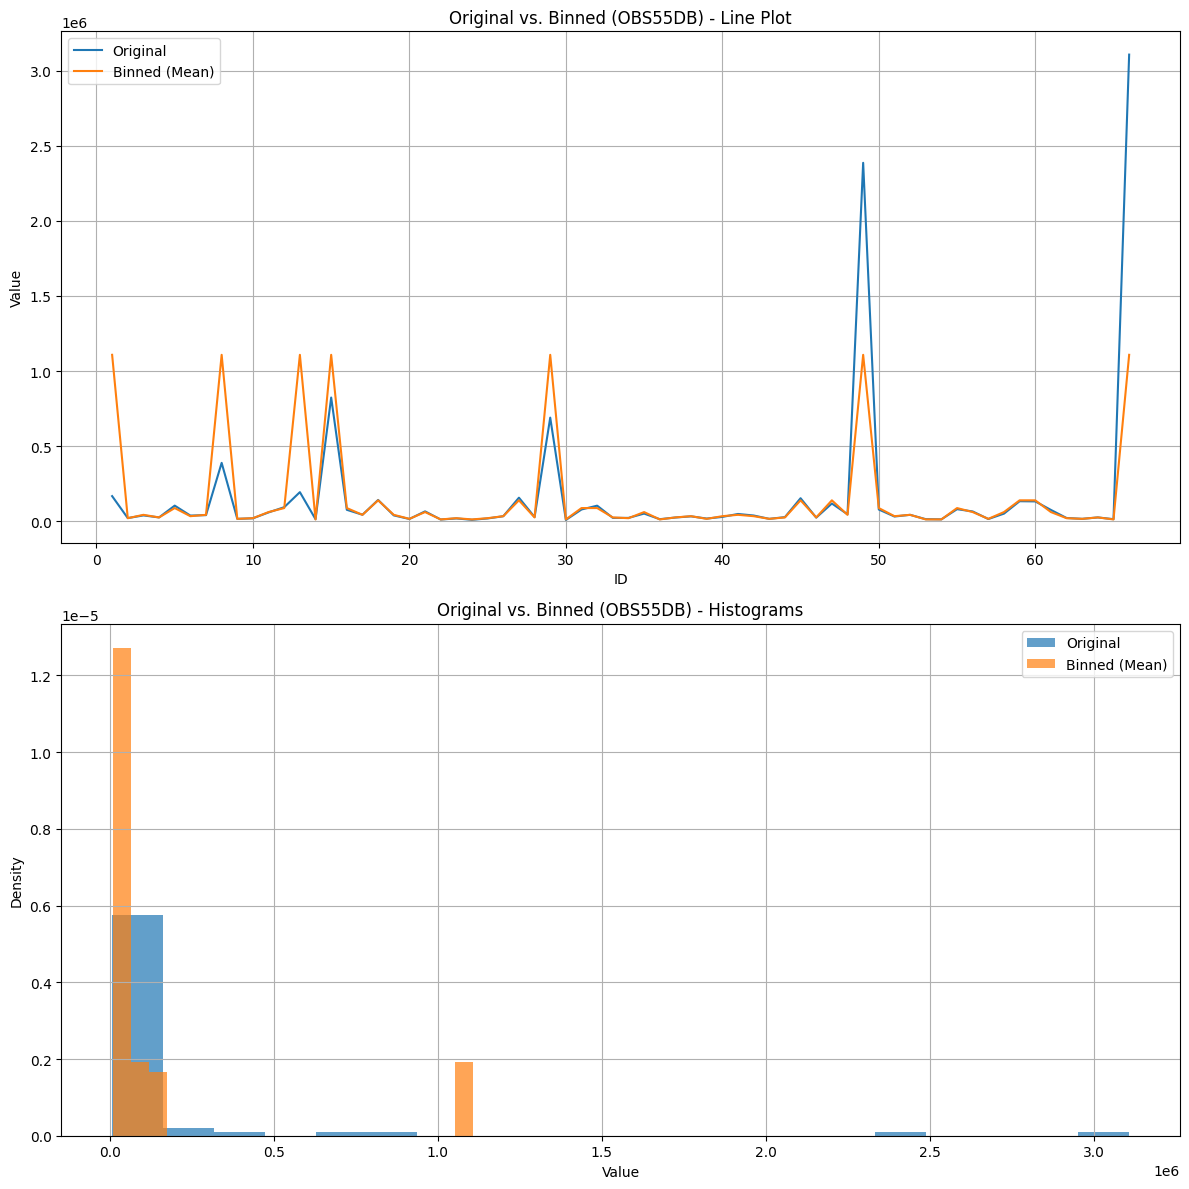

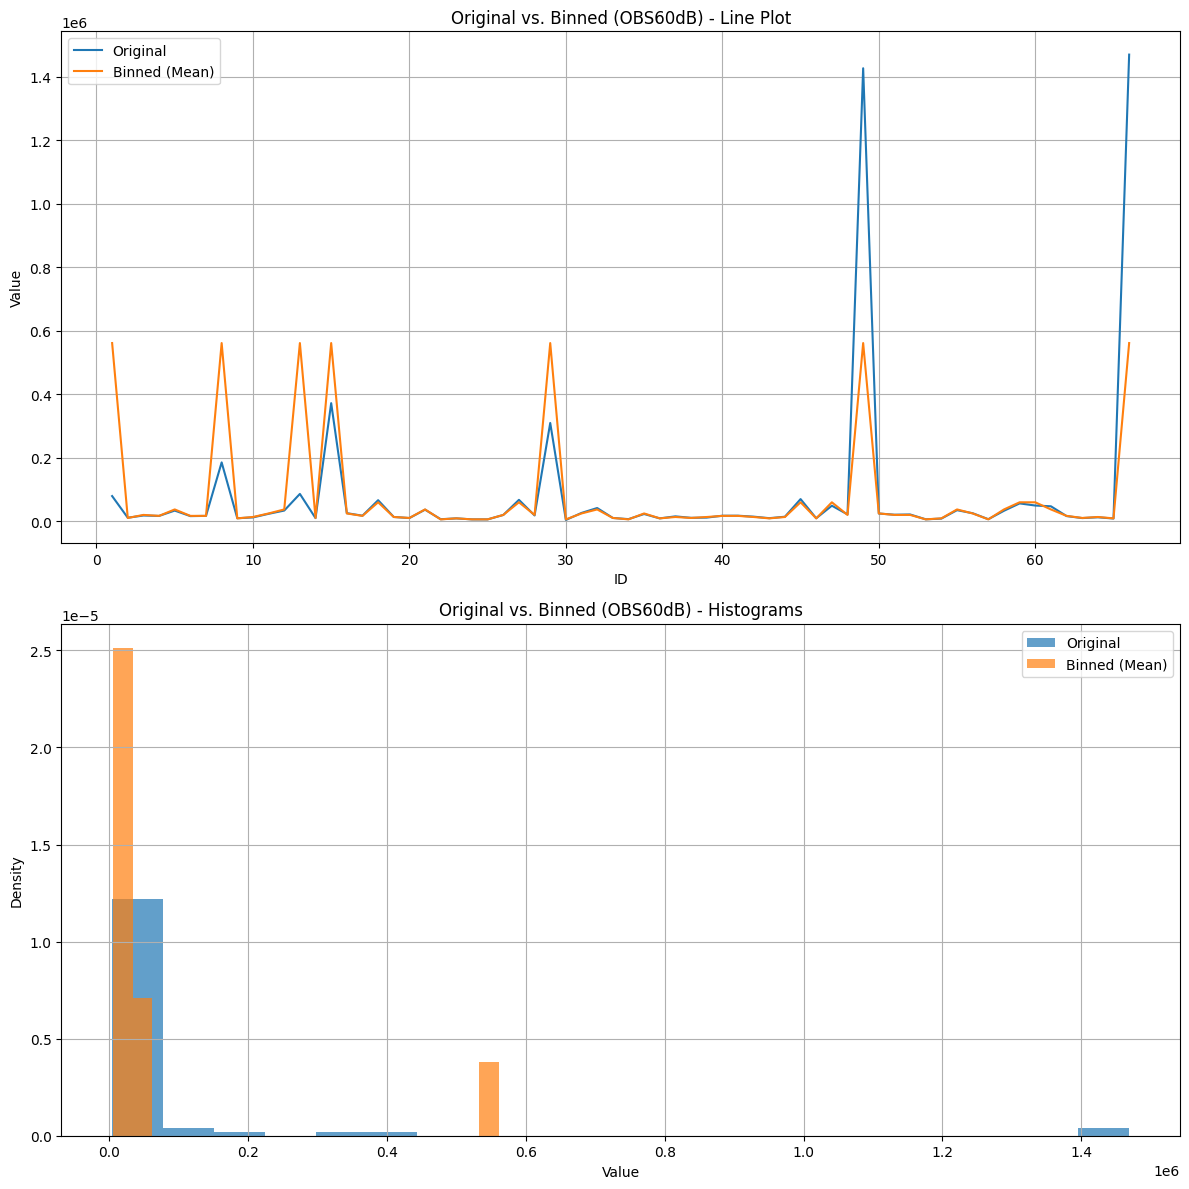

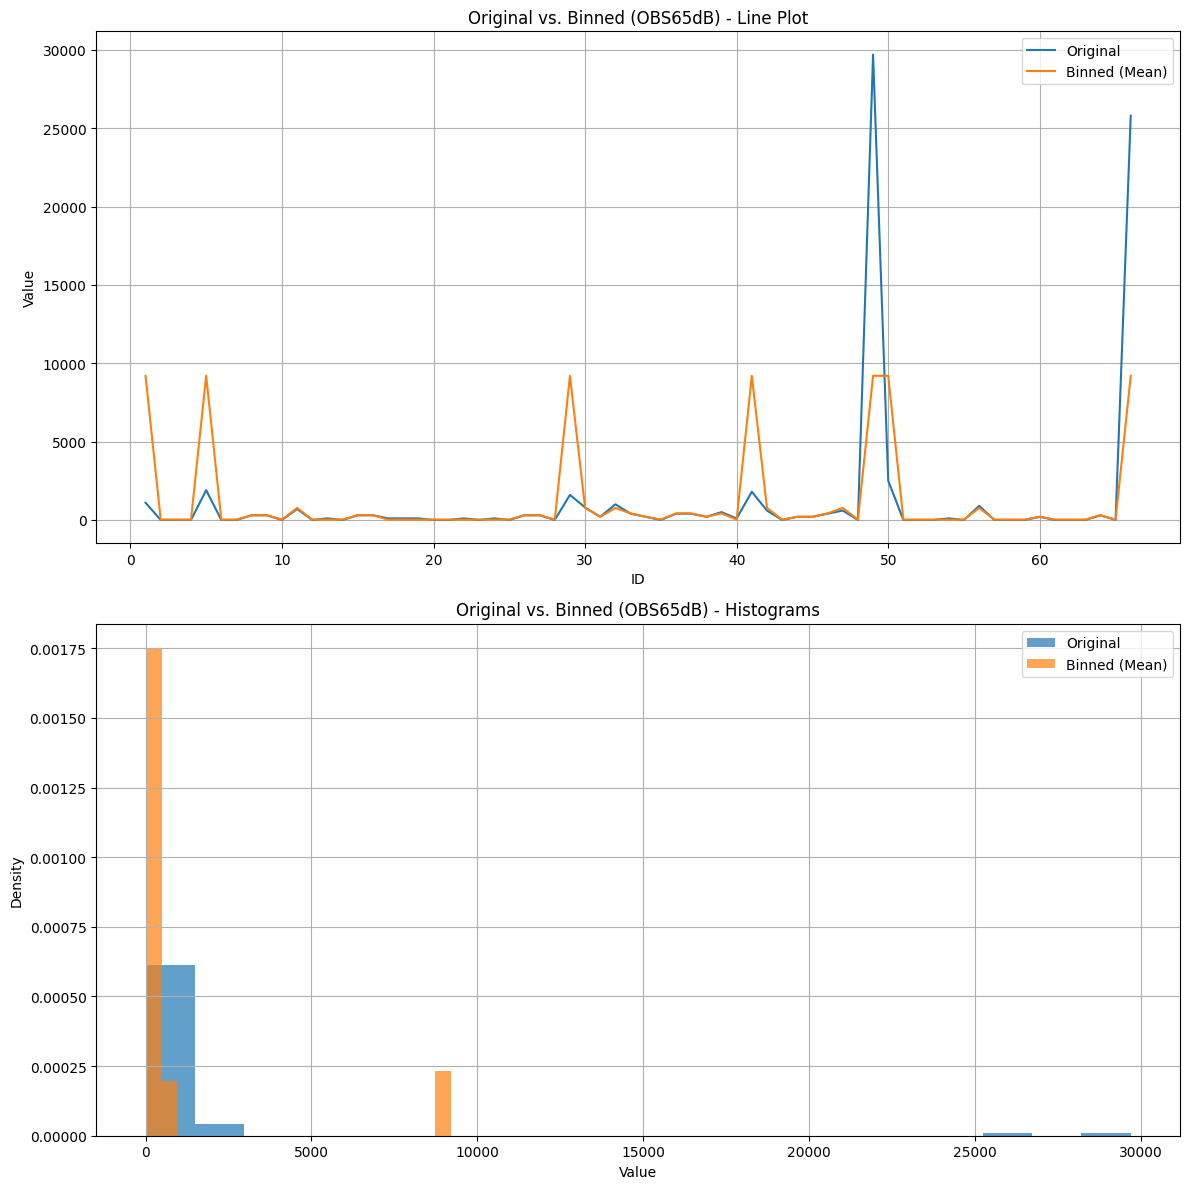

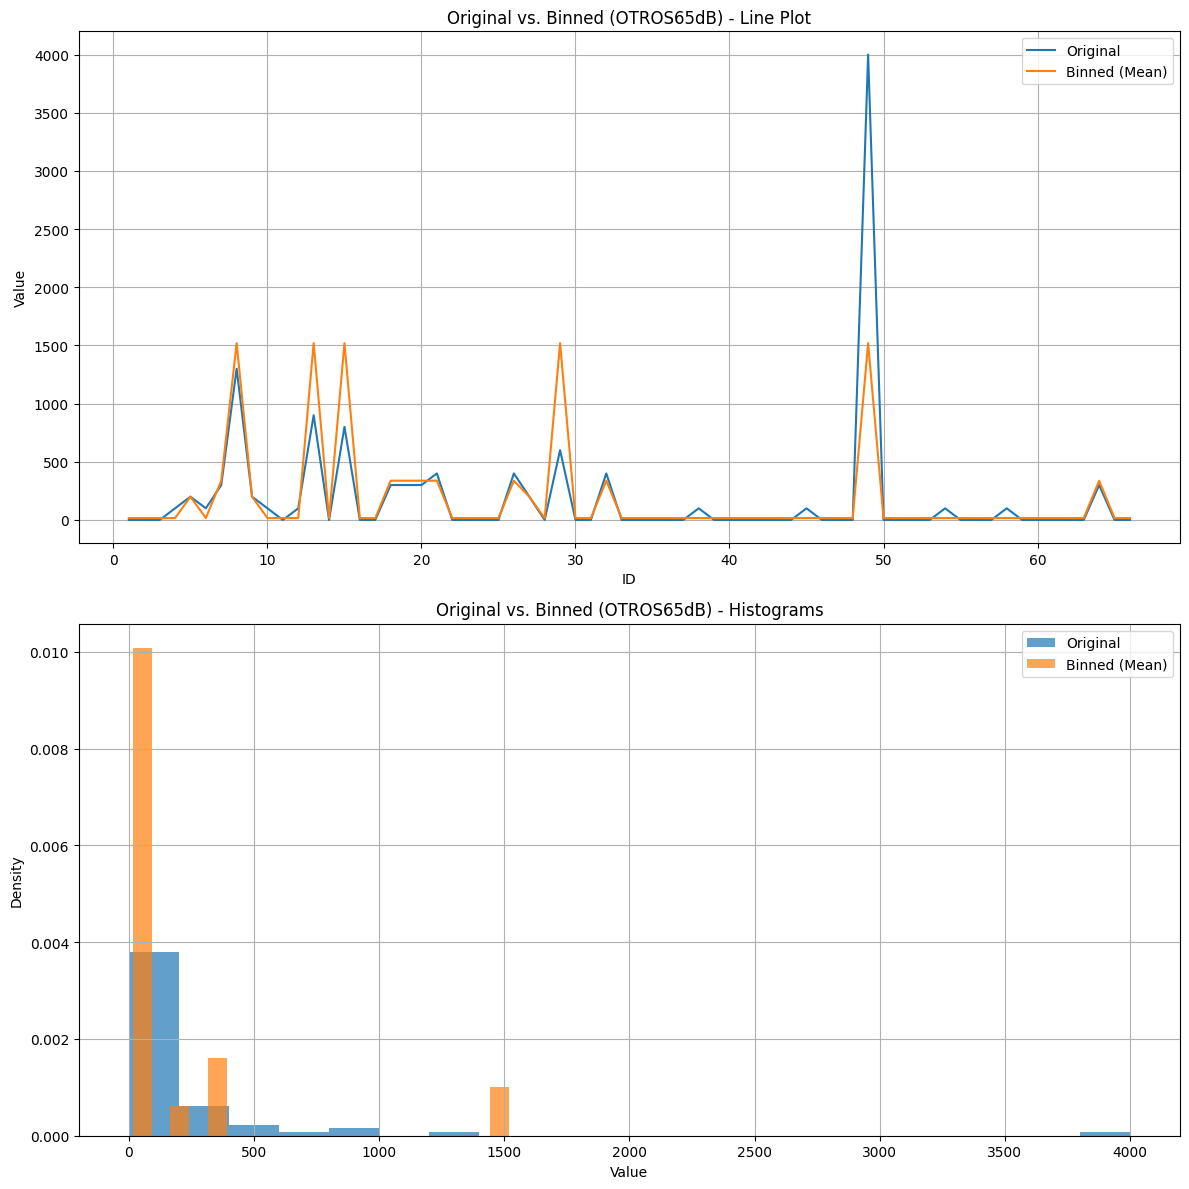

In [46]:
# Plot the original and binned series for comparison
for col in variables_to_analyze:
    plt.figure(figsize=(12, 6))
    plt.plot(df['ID'], df[col], label='Original')
    plt.plot(binned_df['ID'], binned_df[col + '_binned'], label='Binned (Mean)')
    plt.title(f'Original vs. Binned ({col})')
    plt.xlabel('ID')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

b) **Comentarios sobre los resultados observados:**

Al comparar las series originales con las series suavizadas mediante binning por frecuencias iguales y estimación por medias, se pueden observar los siguientes puntos:

*   **Reducción de la variabilidad:** Las series suavizadas muestran una menor variabilidad en comparación con las series originales. Esto es una consecuencia directa del binning, donde los valores dentro de cada bin se reemplazan por la media de ese bin.
*   **Pérdida de detalle:** Si bien el suavizado reduce el ruido y las fluctuaciones, también implica una pérdida de detalle en los datos. La serie binned representa una versión simplificada de la serie original.
*   **Tendencias más claras:** En algunos casos, el suavizado puede ayudar a resaltar las tendencias generales en los datos al reducir el impacto de los valores atípicos y las variaciones menores.
*   **Influencia del número de bins:** El grado de suavizado depende del número de bins utilizados. Un mayor número de bins resultará en un suavizado menor y viceversa. La elección del número de bins dependerá del equilibrio deseado entre la reducción de ruido y la preservación del detalle.

En general, el suavizado por binning es una técnica útil para reducir el ruido y hacer que las tendencias en los datos sean más visibles, pero es importante ser consciente de la pérdida de detalle que implica.

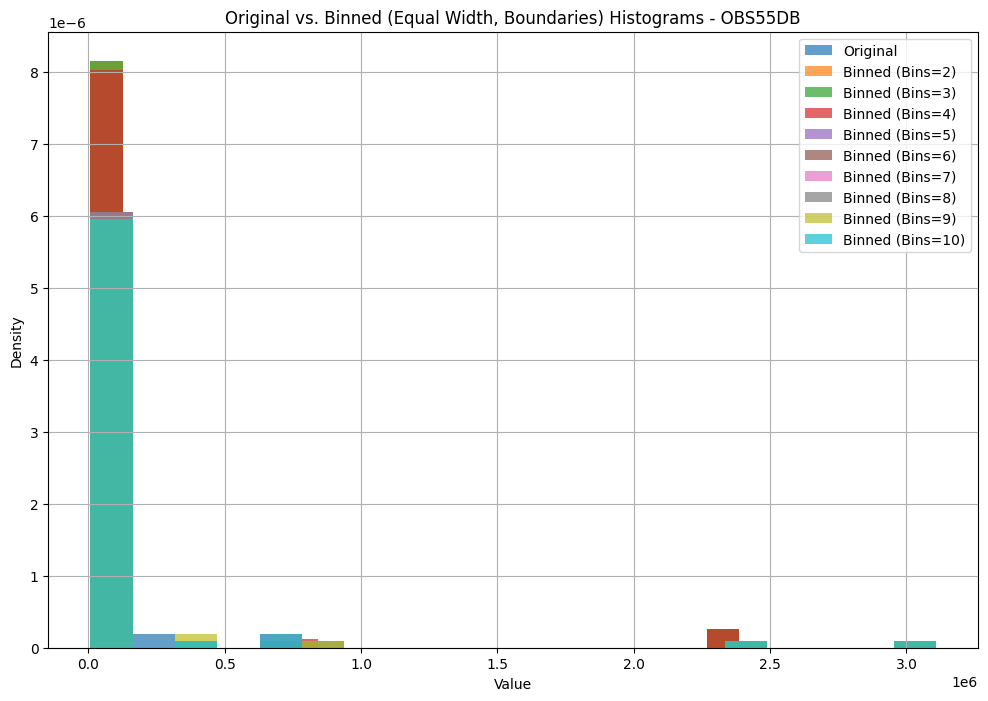

In [47]:
# Function to perform equal width binning with boundary smoothing
def equal_width_binning_boundaries(data, num_bins):
    # Create bins with equal width
    bins = pd.cut(data, bins=num_bins, labels=False, include_lowest=True, duplicates='drop')

    # Calculate the min and max for each bin
    bin_boundaries = data.groupby(bins).agg(['min', 'max'])

    # Map the bin boundaries back to the original data
    binned_data = bins.map(bin_boundaries['min']) # Using the min of the bin as the smoothed value

    return binned_data

# Number of bins to test
bin_ranges = range(2, 11)

# Select the first variable for analysis
col_to_analyze = variables_to_analyze[0]

# Apply binning and plot histograms for the first variable for each number of bins
plt.figure(figsize=(12, 8))
plt.hist(df[col_to_analyze], bins=20, alpha=0.7, label='Original', density=True) # Plot original data histogram

for num_bins in bin_ranges:
    binned_data = equal_width_binning_boundaries(df[col_to_analyze], num_bins)
    plt.hist(binned_data, bins=20, alpha=0.7, label=f'Binned (Bins={num_bins})', density=True)

plt.title(f'Original vs. Binned (Equal Width, Boundaries) Histograms - {col_to_analyze}')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

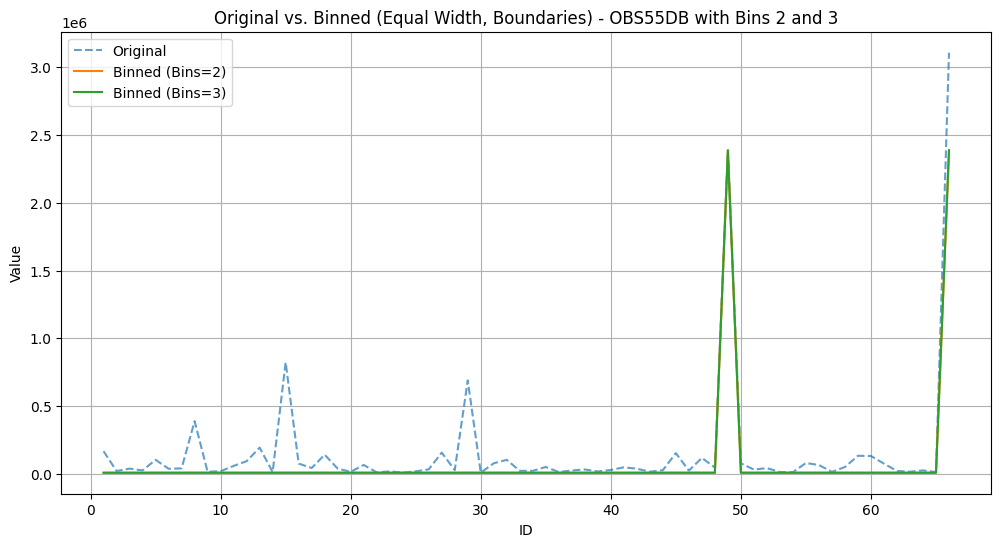

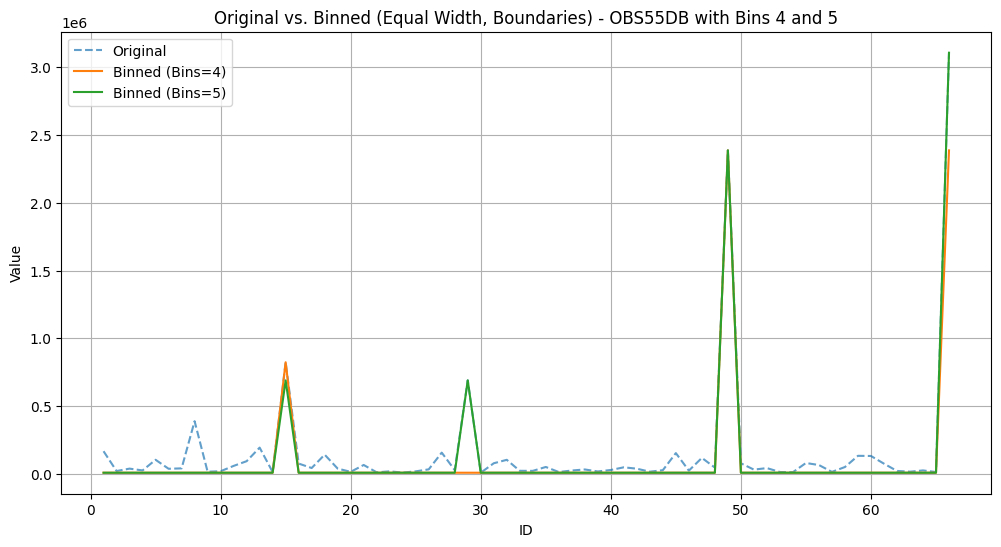

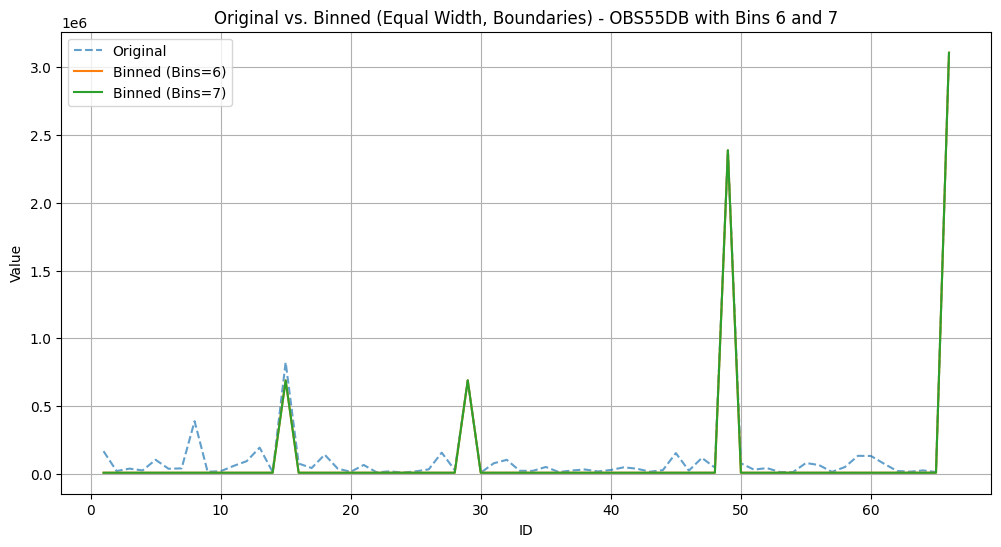

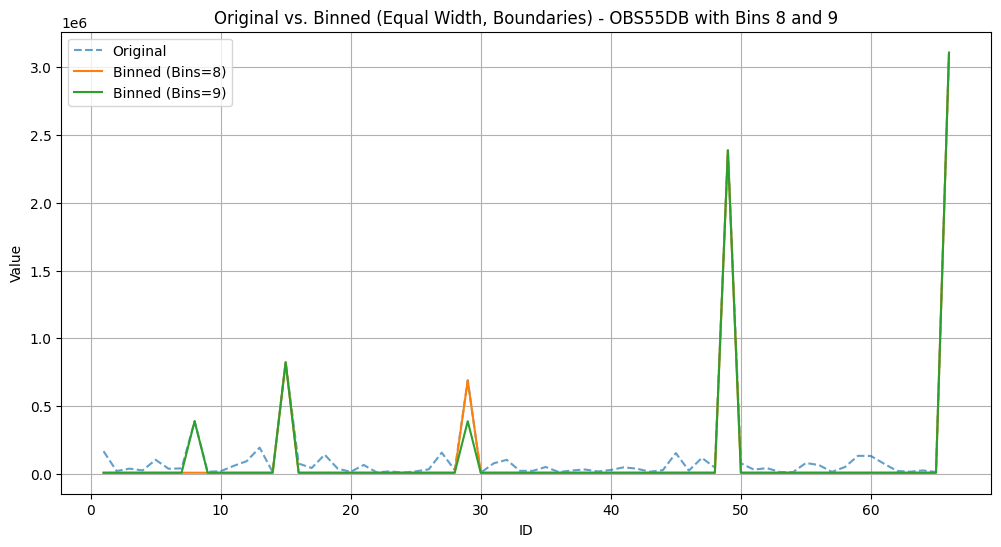

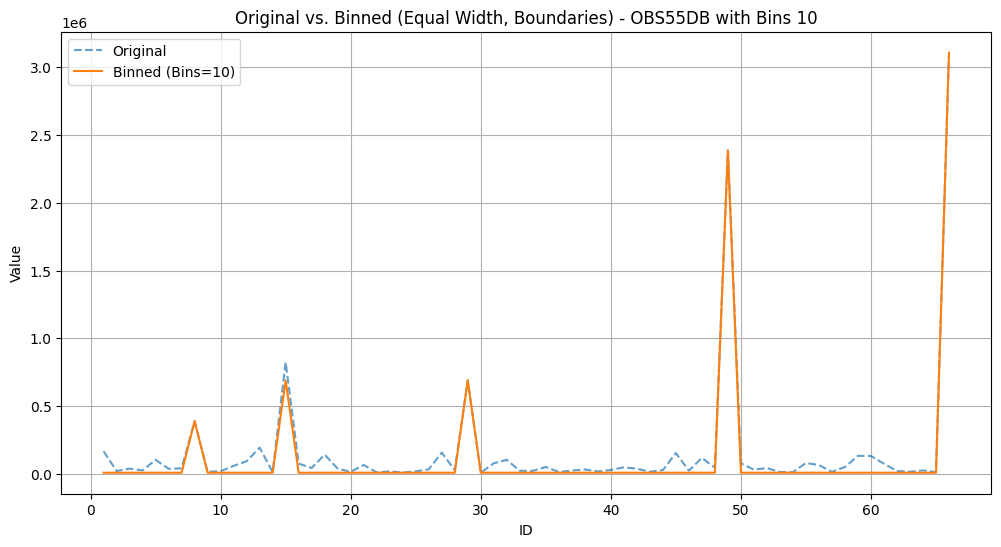

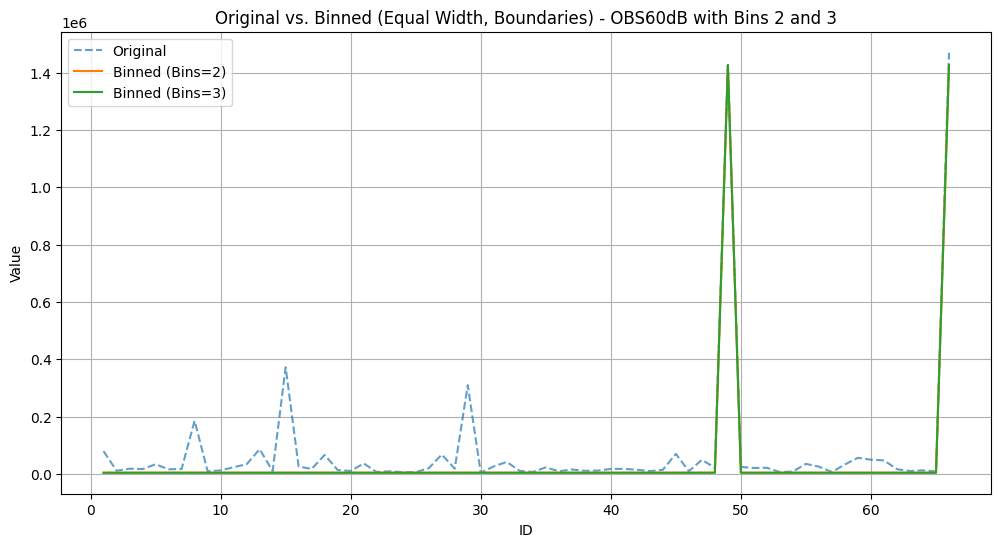

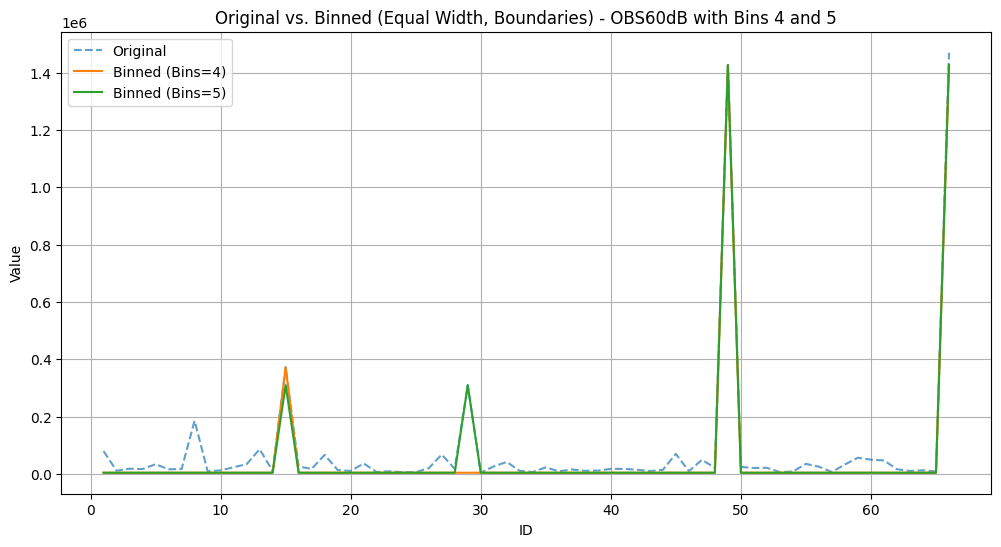

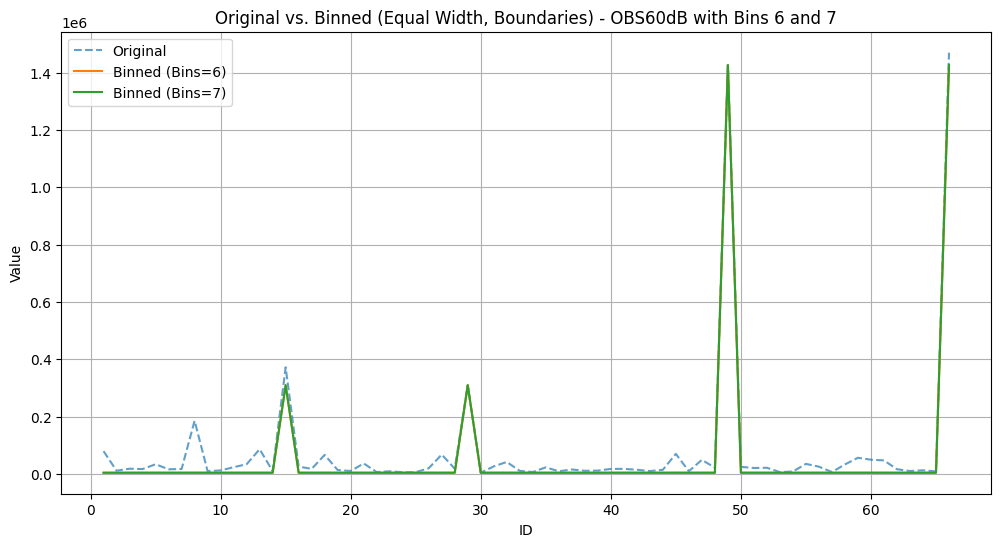

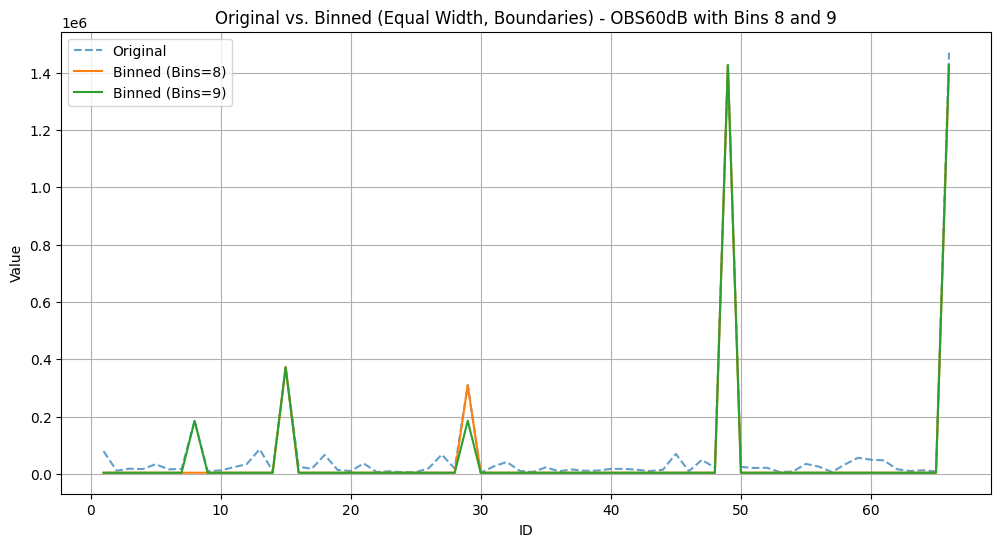

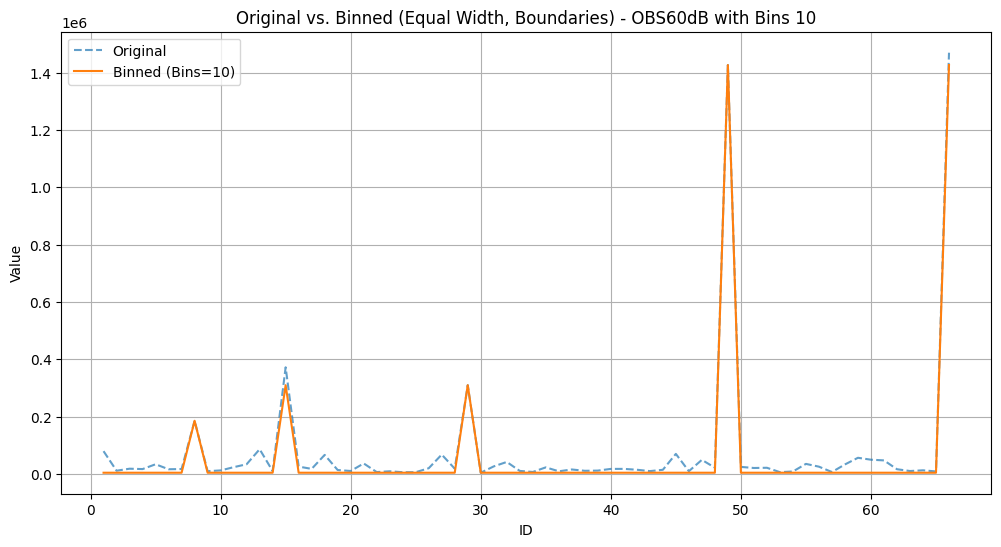

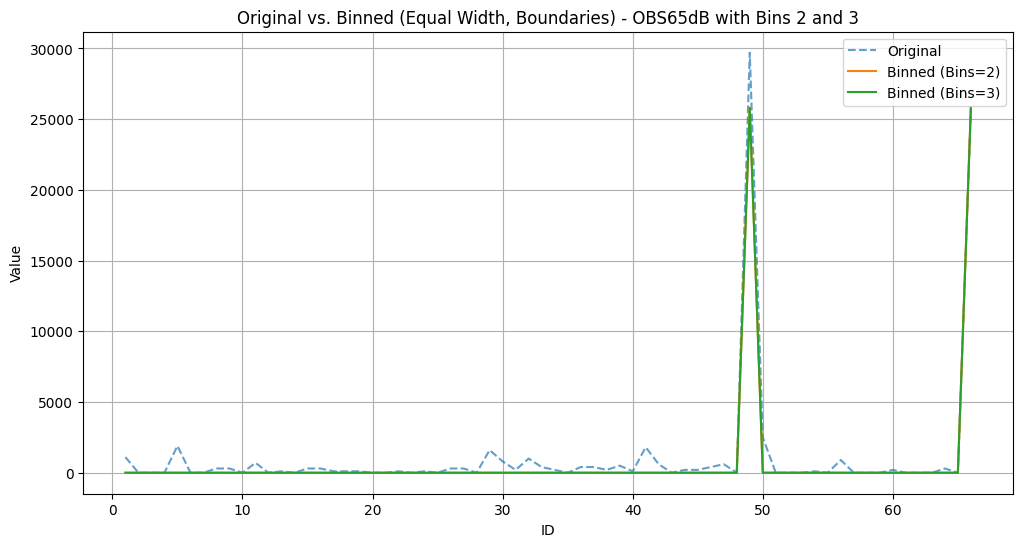

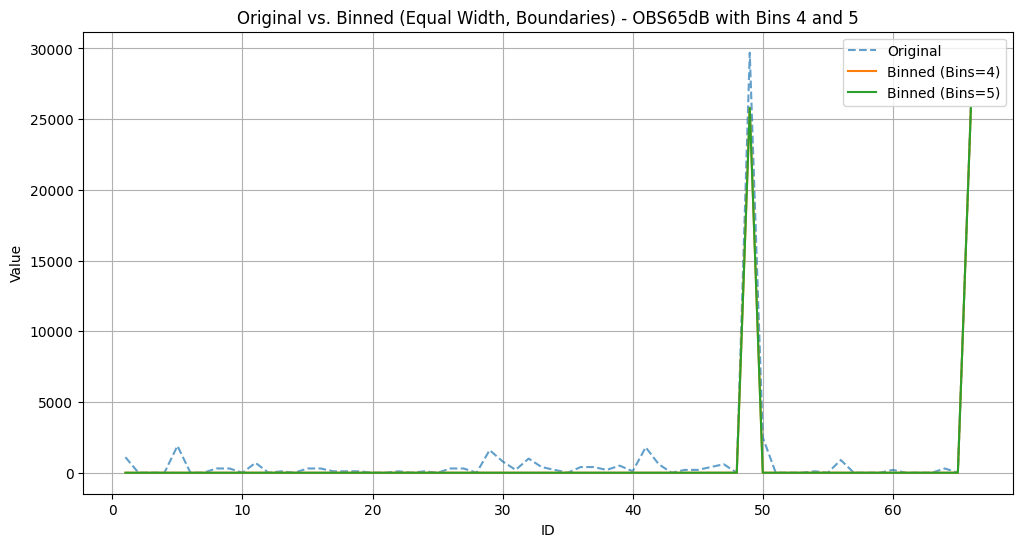

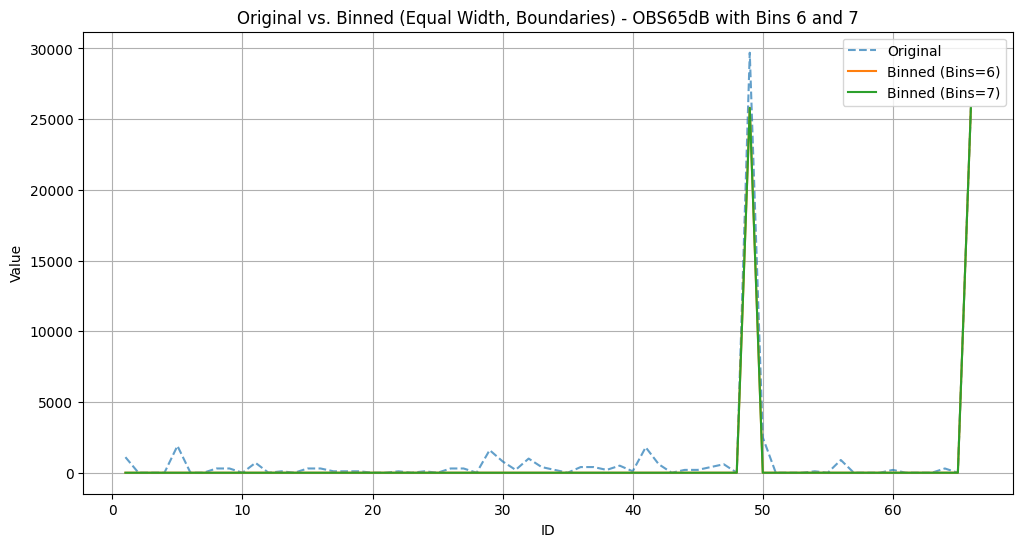

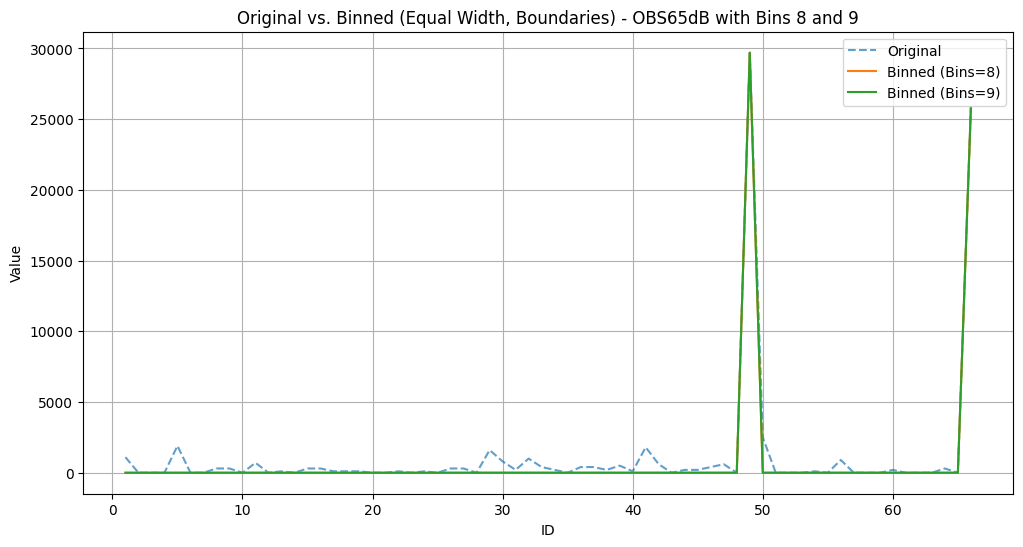

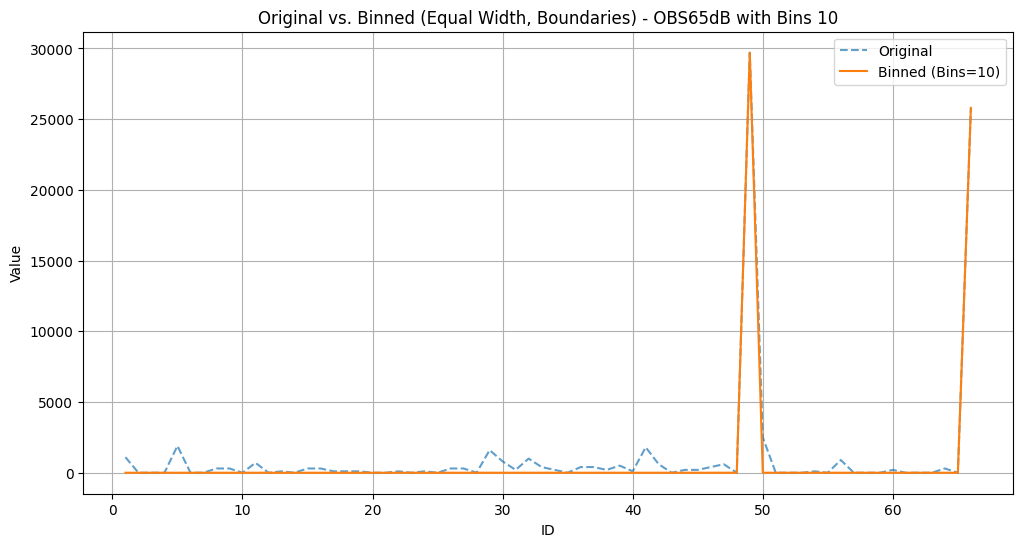

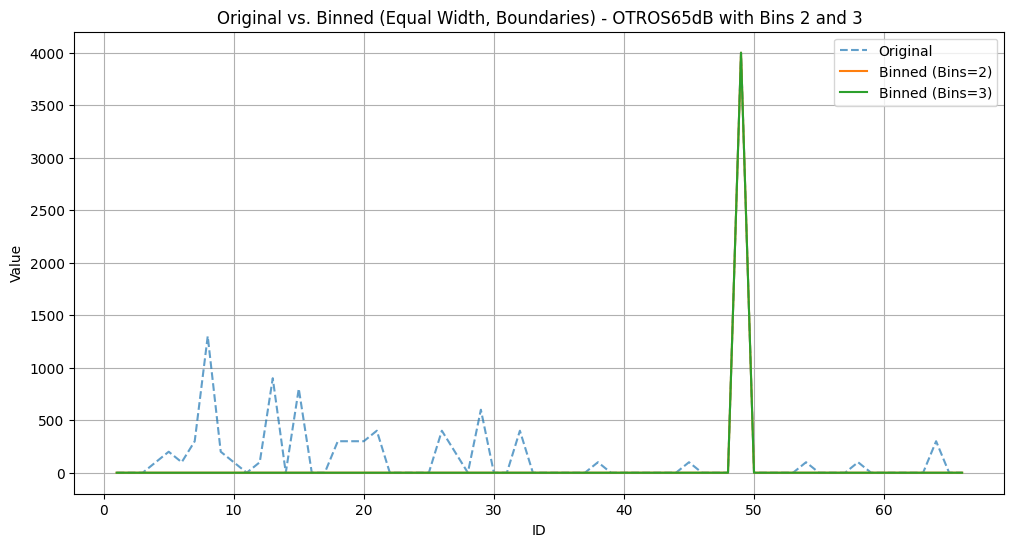

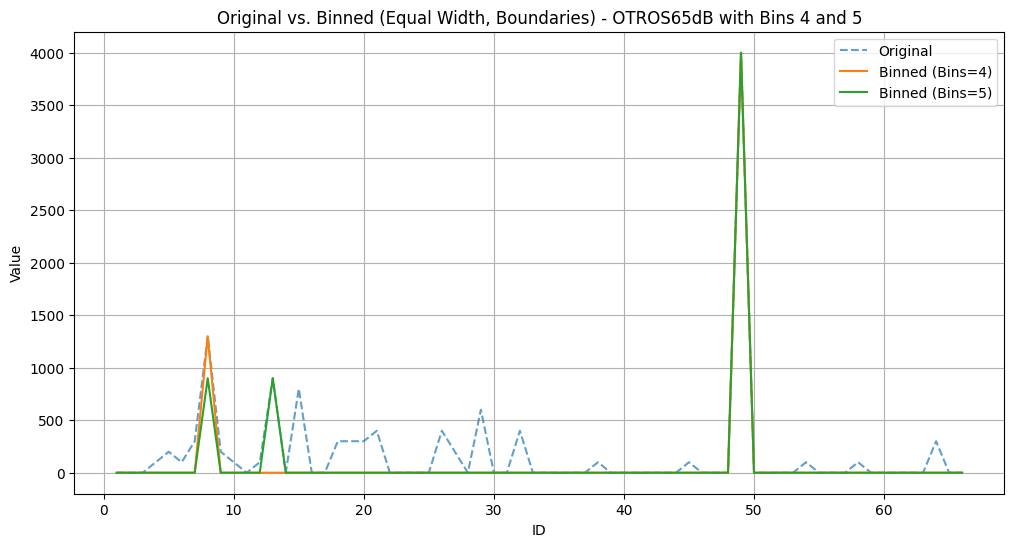

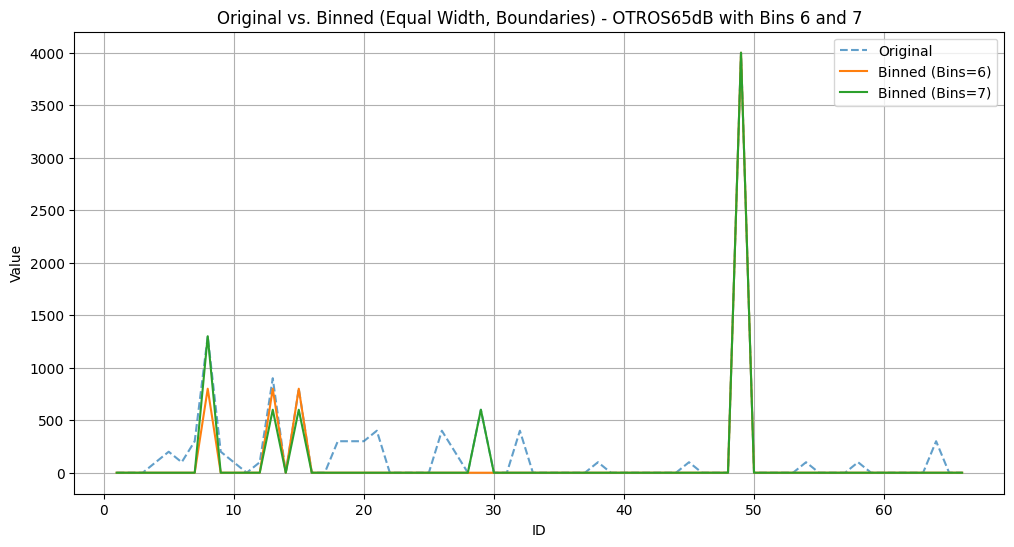

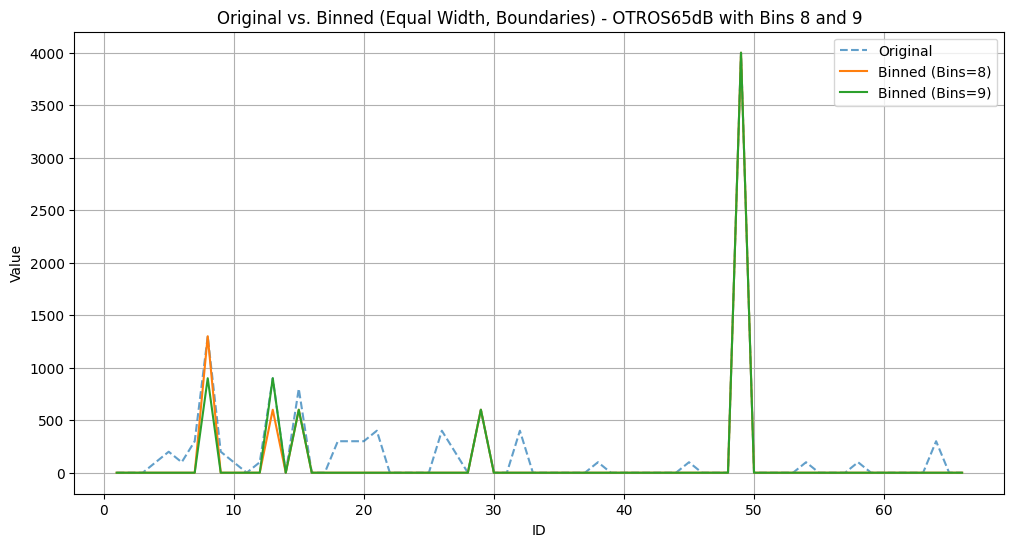

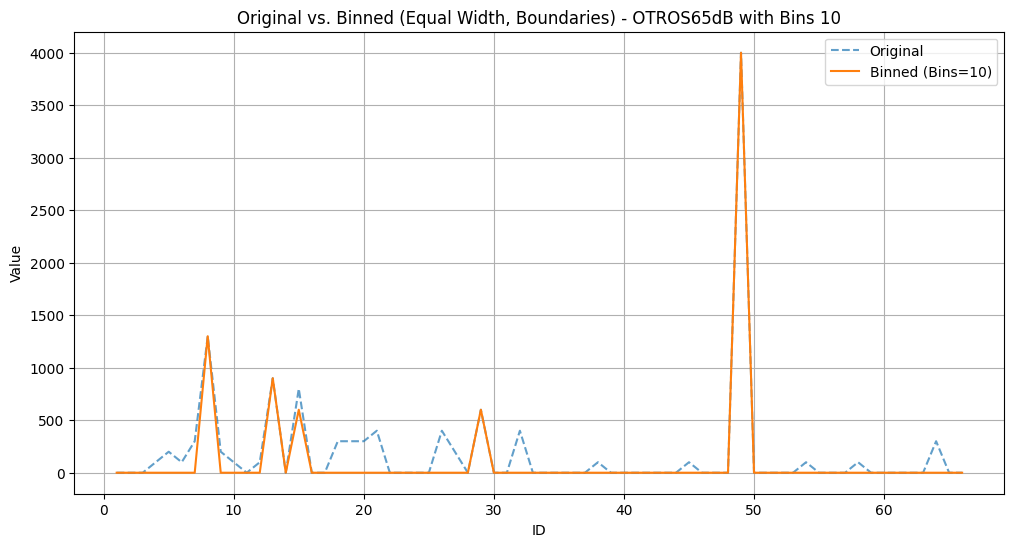

In [6]:
# Number of bins to test
bin_ranges = range(2, 11)

# Apply binning and plot for each variable, showing pairs of binning results
for col in variables_to_analyze:
    for i in range(0, len(bin_ranges), 2):
        plt.figure(figsize=(12, 6))
        plt.plot(df['ID'], df[col], label='Original', alpha=0.7, linestyle='--') # Plot original data with transparency and dashed line

        # Plot for the current bin number
        num_bins1 = bin_ranges[i]
        binned_data1 = equal_width_binning_boundaries(df[col], num_bins1)
        plt.plot(df['ID'], binned_data1, label=f'Binned (Bins={num_bins1})')

        # Plot for the next bin number if it exists
        if i + 1 < len(bin_ranges):
            num_bins2 = bin_ranges[i + 1]
            binned_data2 = equal_width_binning_boundaries(df[col], num_bins2)
            plt.plot(df['ID'], binned_data2, label=f'Binned (Bins={num_bins2})')

        plt.title(f'Original vs. Binned (Equal Width, Boundaries) - {col} with Bins {num_bins1}' + (f' and {num_bins2}' if i + 1 < len(bin_ranges) else ''))
        plt.xlabel('ID')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

c) A medida que aumentan los bins, no parece seguir ningun patron especifico, pero
van apareciendo y desapareciendo picos de la grafica.

Using Colab cache for faster access to the 'weather-dataset' dataset.


Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13   
1                   259.0          15.8263         0.0               1015.63   
2                   204.0          14.9569         0.0               1015.94   
3                   269.0          15.8263         0.0               1016.41   
4                   259.0          15.8263         0.0               1016.51   

                       Daily Summary  
0  Partly cloudy throughout the day.  
1  Partly cloudy throughout the day.  
2  Partly cloudy throughout the day.  
3  Partly cloudy throughout the day.  
4  Partly cloudy throughout the day.

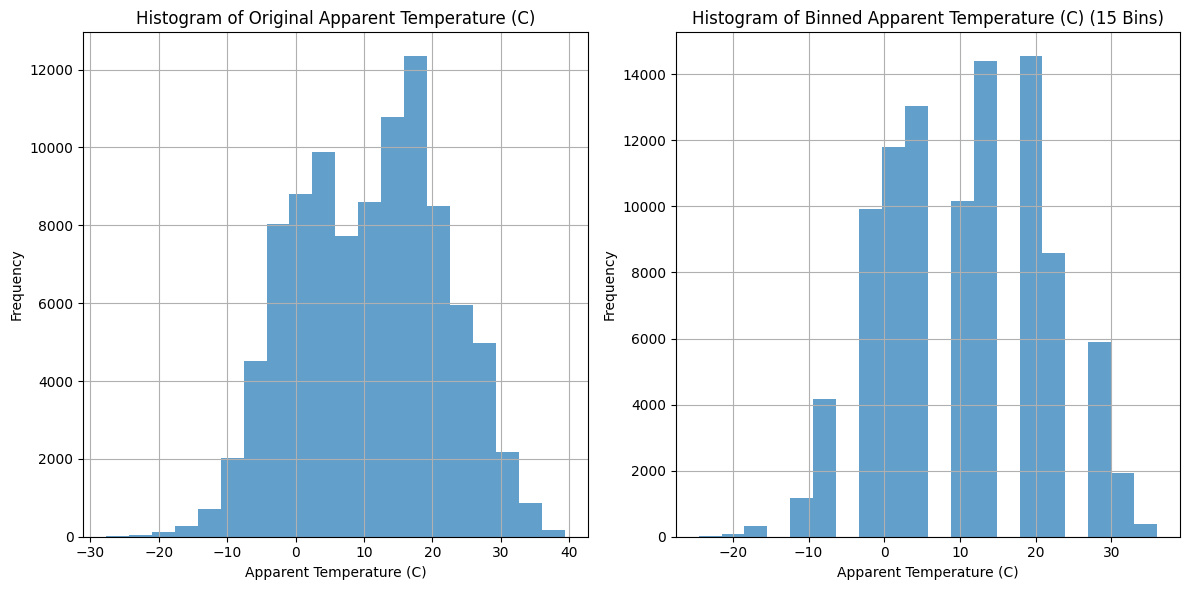

In [59]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt

# Download latest version
dd_path = kagglehub.dataset_download("muthuj7/weather-dataset")

# Construct the full path to the CSV file
csv_file_path = os.path.join(dd_path, 'weatherHistory.csv')

# Read the CSV file
dd = pd.read_csv(csv_file_path)

# Display the head of the DataFrame
display(dd.head())

# Generate a histogram of 'Apparent Temperature (C)'
plt.figure(figsize=(12, 6)) # Increased figure size

plt.subplot(1, 2, 1) # Subplot for original histogram
plt.hist(dd['Apparent Temperature (C)'], bins=20, alpha=0.7)
plt.title('Histogram of Original Apparent Temperature (C)')
plt.xlabel('Apparent Temperature (C)')
plt.ylabel('Frequency')
plt.grid(True)

# Apply equal width binning
# Assuming the equal_width_binning function is available in the notebook's environment
# If not, you would need to define or import it here.
num_bins = 15
apparent_temp_binned_equal_width = equal_width_binning(dd['Apparent Temperature (C)'], num_bins)


# Generate a histogram of the binned 'Apparent Temperature (C)'
plt.subplot(1, 2, 2) # Subplot for binned histogram
plt.hist(apparent_temp_binned_equal_width, bins=20, alpha=0.7)
plt.title(f'Histogram of Binned Apparent Temperature (C) ({num_bins} Bins)')
plt.xlabel('Apparent Temperature (C)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

d)

## 2 - Deteccion de outliers

In [7]:
# wh_file_path = '/home/weather.csv'

wh = pd.read_csv('https://raw.githubusercontent.com/bdm-unlu/2025/main/TPs/TP01/weather.csv')
# wh = pd.read_csv(wh_file_path)
print("Dimensiones:", wh.shape)
display(wh.head())

Dimensiones: (13200, 11)


Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
0         14.0        73         9.5               82.0  partly cloudy   
1         39.0        96         8.5               71.0  partly cloudy   
2         30.0        64         7.0               16.0          clear   
3         38.0        83         1.5               82.0          clear   
4         27.0        74        17.0               66.0       overcast   

   Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  \
0               1010.82         2  Winter              3.5    inland   
1               1011.43         7  Spring             10.0    inland   
2               1018.72         5  Spring              5.5  mountain   
3               1026.25         7  Spring              1.0   coastal   
4                990.67         1  Winter              2.5  mountain   

  Weather Type  
0        Rainy  
1       Cloudy  
2        Sunny  
3        Sunny  
4        Rainy

In [8]:
# Select numerical columns for outlier detection (excluding non-numerical columns like 'Cloud Cover', 'Season', 'Location', 'Weather Type')
numerical_cols = wh.select_dtypes(include=np.number).columns.tolist()

# Remove 'ID' if it exists, as it's likely just an identifier
if 'ID' in numerical_cols:
    numerical_cols.remove('ID')

outliers = {}
for col in numerical_cols:
    Q1 = wh[col].quantile(0.25)
    Q3 = wh[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    col_outliers = wh[(wh[col] < lower_bound) | (wh[col] > upper_bound)]

    if not col_outliers.empty:
        outliers[col] = col_outliers

# Display the identified outliers
if outliers:
    print("Identified Outliers (based on IQR):")
    for col, outlier_df in outliers.items():
        print(f"\nOutliers in '{col}':")
        display(outlier_df)
else:
    print("No significant outliers detected based on the IQR method.")

Identified Outliers (based on IQR):

Outliers in 'Temperature':


Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
210           78.0        81         8.0               78.0       overcast   
228           73.0        82        47.0              107.0       overcast   
535           80.0        76         3.0               93.0          clear   
709           74.0       101        18.0               76.0  partly cloudy   
730           76.0        91        13.5               82.0  partly cloudy   
...            ...       ...         ...                ...            ...   
12752         90.0        83        15.0               98.0          clear   
12814         72.0        88        12.0               83.0          clear   
12878         95.0        96         1.0               84.0  partly cloudy   
13065         97.0        95         7.5               79.0          clear   
13108         81.0        81        10.5               96.0          clear   

       Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  \
210                 1010.19         1  Autumn              4.5    inland   
228                 1002.73         0  Winter              0.5  mountain   
535                 1014.26        13  Winter              3.0    inland   
709                 1010.82         6  Spring              4.0   coastal   
730                 1015.18         1  Autumn              7.0    inland   
...                     ...       ...     ...              ...       ...   
12752               1028.13         2  Summer             10.0    inland   
12814               1015.17        13  Winter              5.5   coastal   
12878               1027.98         7  Spring              3.0  mountain   
13065               1029.30         9  Winter              4.0  mountain   
13108               1022.66        11  Summer              3.5    inland   

      Weather Type  
210         Cloudy  
228          Rainy  
535          Sunny  
709          Sunny  
730         Cloudy  
...            ...  
12752        Sunny  
12814        Sunny  
12878        Sunny  
13065        Sunny  
13108        Sunny  

[92 rows x 11 columns]


Outliers in 'Wind Speed':


Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
63             3.0        75        46.5               87.0       overcast   
90            15.0        81        28.5               71.0  partly cloudy   
123           -3.0        92        28.0               99.0  partly cloudy   
208           34.0        99        34.0               74.0  partly cloudy   
228           73.0        82        47.0              107.0       overcast   
...            ...       ...         ...                ...            ...   
12999         -2.0        90        28.5               84.0       overcast   
13066          5.0       102        31.0              108.0  partly cloudy   
13113         42.0       106        32.5              103.0  partly cloudy   
13115         40.0        75        26.5               78.0  partly cloudy   
13176         19.0       100        36.0               86.0       overcast   

       Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  \
63                   996.85         5  Winter              4.5    inland   
90                  1008.00         4  Winter              6.0    inland   
123                  987.70         1  Winter              4.5  mountain   
208                 1016.03         9  Autumn              1.0    inland   
228                 1002.73         0  Winter              0.5  mountain   
...                     ...       ...     ...              ...       ...   
12999                992.14        14  Winter              4.5  mountain   
13066               1005.89        10  Summer              2.0    inland   
13113                996.45        14  Spring              1.0  mountain   
13115               1011.36         0  Spring              4.5  mountain   
13176                995.12         5  Spring              1.0  mountain   

      Weather Type  
63           Snowy  
90          Cloudy  
123          Snowy  
208          Rainy  
228          Rainy  
...            ...  
12999        Snowy  
13066        Rainy  
13113        Rainy  
13115       Cloudy  
13176        Rainy  

[404 rows x 11 columns]


Outliers in 'Atmospheric Pressure':


Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
10            35.0        45         6.0               86.0  partly cloudy   
38            -9.0        49         1.5               58.0  partly cloudy   
58            31.0        70         0.5               69.0       overcast   
72            11.0        52         6.0               97.0       overcast   
85            32.0        35         2.5               63.0  partly cloudy   
...            ...       ...         ...                ...            ...   
13167         33.0        73         5.0               31.0  partly cloudy   
13168         44.0        45         7.0               28.0  partly cloudy   
13178          0.0        50        11.5               82.0         cloudy   
13184          3.0        62         7.5               14.0       overcast   
13196         -1.0        76         3.5               23.0         cloudy   

       Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  \
10                   879.88         2  Spring              1.0  mountain   
38                  1132.20         8  Spring             16.5  mountain   
58                  1074.07         3  Spring             12.5    inland   
72                  1063.39         7  Summer             12.5    inland   
85                  1160.48         2  Winter              0.0   coastal   
...                     ...       ...     ...              ...       ...   
13167                840.06         9  Spring             10.5   coastal   
13168                894.65         5  Spring             11.5    inland   
13178                822.40         8  Spring             15.5   coastal   
13184               1128.35         3  Summer              7.5  mountain   
13196               1067.23         1  Winter              6.0   coastal   

      Weather Type  
10          Cloudy  
38           Snowy  
58           Sunny  
72           Snowy  
85           Sunny  
...            ...  
13167       Cloudy  
13168        Sunny  
13178       Cloudy  
13184        Rainy  
13196        Snowy  

[927 rows x 11 columns]


Outliers in 'Visibility (km)':


Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
38            -9.0        49         1.5               58.0  partly cloudy   
113           18.0        60        12.5               42.0       overcast   
134           29.0        77         0.5               91.0         cloudy   
300           48.0        79        12.0               88.0  partly cloudy   
359            5.0        36        14.5               68.0         cloudy   
...            ...       ...         ...                ...            ...   
13018         -9.0        32         5.0               21.0  partly cloudy   
13025         66.0       100         7.0              109.0          clear   
13083         16.0        71         3.0               43.0       overcast   
13163          5.0        67         9.5               71.0  partly cloudy   
13178          0.0        50        11.5               82.0         cloudy   

       Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  \
38                  1132.20         8  Spring             16.5  mountain   
113                  822.66         2  Summer             17.5  mountain   
134                  934.49        14  Autumn             17.0    inland   
300                 1140.24         4  Autumn             17.0  mountain   
359                 1195.34         1  Autumn             16.0    inland   
...                     ...       ...     ...              ...       ...   
13018                966.64        11  Spring             16.5   coastal   
13025               1018.30        12  Autumn             14.5  mountain   
13083                920.13        10  Summer             15.0    inland   
13163               1122.86         4  Spring             15.0  mountain   
13178                822.40         8  Spring             15.5   coastal   

      Weather Type  
38           Snowy  
113          Rainy  
134          Sunny  
300          Snowy  
359          Rainy  
...            ...  
13018        Snowy  
13025        Sunny  
13083       Cloudy  
13163       Cloudy  
13178       Cloudy  

[383 rows x 11 columns]

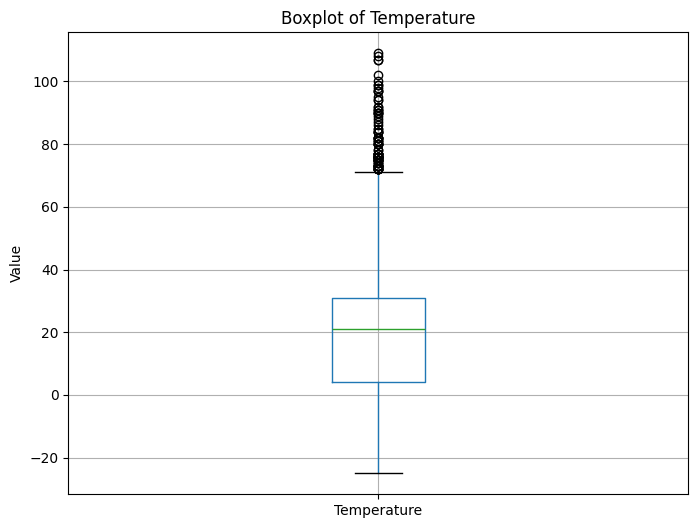

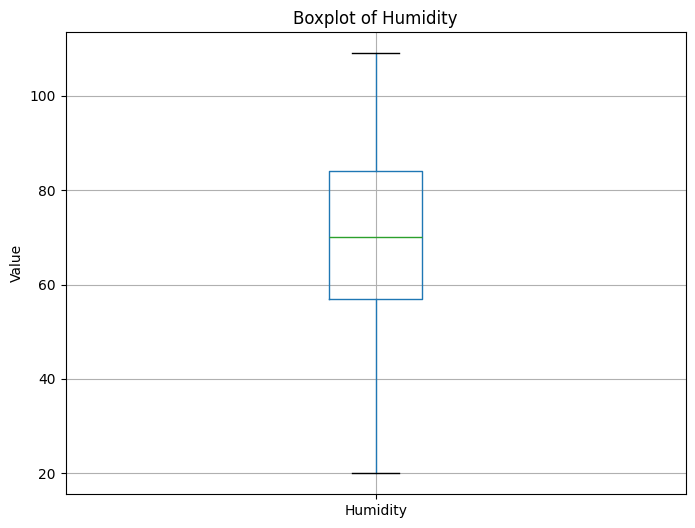

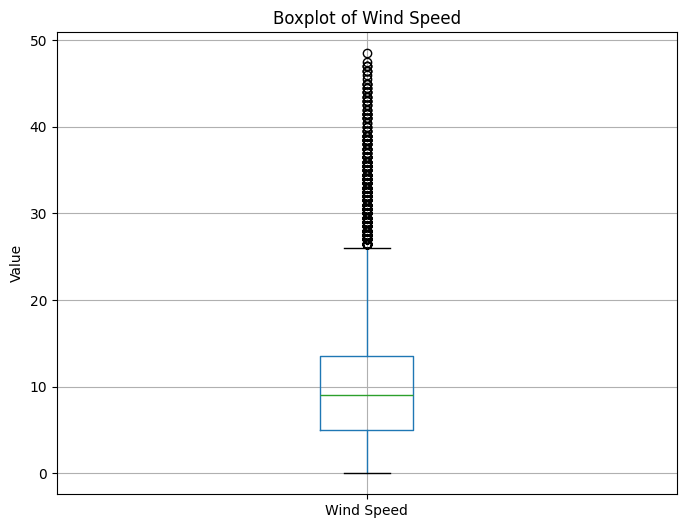

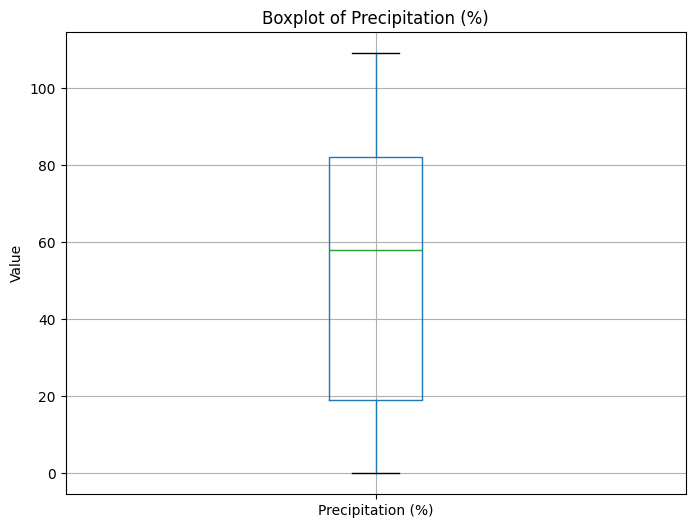

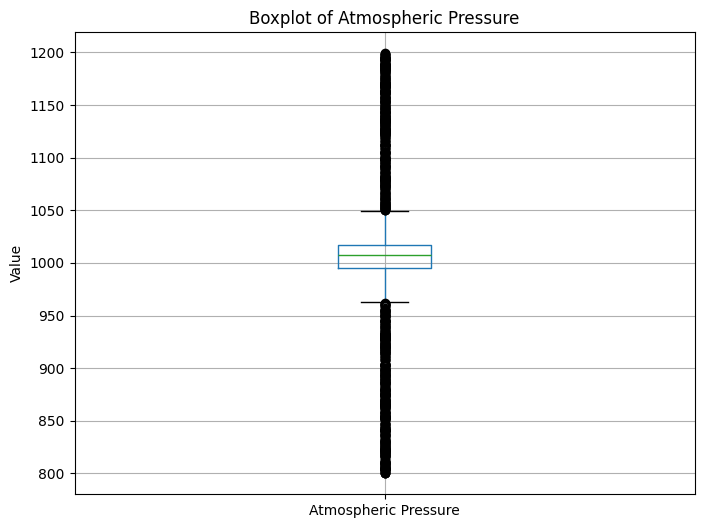

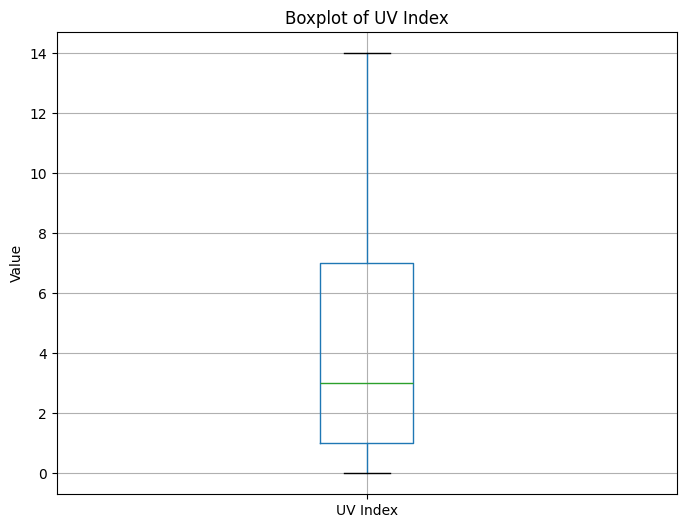

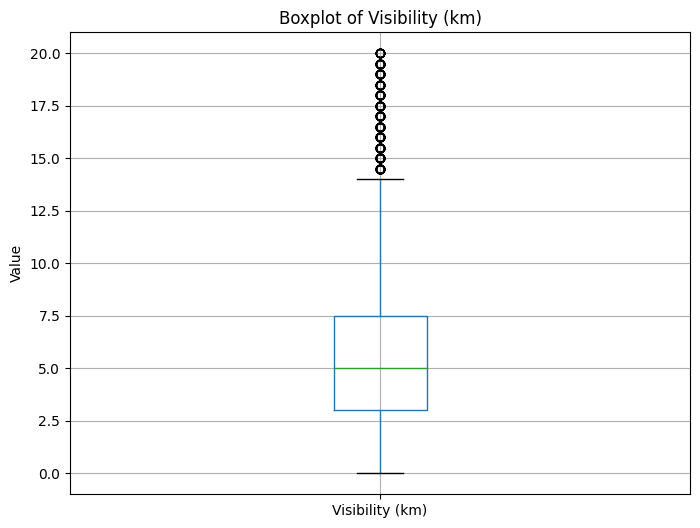

In [9]:
import matplotlib.pyplot as plt

# Select numerical columns for plotting
numerical_cols = wh.select_dtypes(include=np.number).columns.tolist()

# Remove 'ID' if it exists, as it's likely just an identifier
if 'ID' in numerical_cols:
    numerical_cols.remove('ID')

# Create boxplots for each numerical column
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    wh.boxplot(column=col)
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Value')
    plt.show()

In [10]:
# Calculate mean and standard deviation for each numerical column
mean = wh[numerical_cols].mean()
std = wh[numerical_cols].std()

print("Z-scores of identified outliers:")
for col, outlier_df in outliers.items():
    print(f"\nOutliers in '{col}':")
    # Calculate the z-score for each outlier
    z_scores = (outlier_df[col] - mean[col]) / std[col]
    display(z_scores.to_frame(name='Z-score'))

Z-scores of identified outliers:

Outliers in 'Temperature':


Z-score
210    3.386134
228    3.098551
535    3.501167
709    3.156068
730    3.271101
...         ...
12752  4.076331
12814  3.041035
12878  4.363913
13065  4.478946
13108  3.558683

[92 rows x 1 columns]


Outliers in 'Wind Speed':


Z-score
63     5.307479
90     2.702070
123    2.629698
208    3.498167
228    5.379852
...         ...
12999  2.702070
13066  3.063932
13113  3.281050
13115  2.412580
13176  3.787657

[404 rows x 1 columns]


Outliers in 'Atmospheric Pressure':


Z-score
10    -3.385734
38     3.397137
58     1.834485
72     1.547385
85     4.157361
...         ...
13167 -4.456176
13168 -2.988686
13178 -4.930912
13184  3.293641
13196  1.650612

[927 rows x 1 columns]


Outliers in 'Visibility (km)':


Z-score
38     3.273643
113    3.570247
134    3.421945
300    3.421945
359    3.125341
...         ...
13018  3.273643
13025  2.680435
13083  2.828737
13163  2.828737
13178  2.977039

[383 rows x 1 columns]

In [11]:
is_outlier_dict = {}

for col in numerical_cols:
    Q1 = wh[col].quantile(0.25)
    Q3 = wh[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    is_outlier_dict[col] = (wh[col] < lower_bound) | (wh[col] > upper_bound)

In [12]:
is_outlier_df = pd.DataFrame(is_outlier_dict)
display(is_outlier_df.head())

# Calculate and display the total number of outliers per column
total_outliers_per_column = is_outlier_df.sum()
print("\nTotal number of outliers per column:")
display(total_outliers_per_column)

Temperature  Humidity  Wind Speed  Precipitation (%)  Atmospheric Pressure  \
0        False     False       False              False                 False   
1        False     False       False              False                 False   
2        False     False       False              False                 False   
3        False     False       False              False                 False   
4        False     False       False              False                 False   

   UV Index  Visibility (km)  
0     False            False  
1     False            False  
2     False            False  
3     False            False  
4     False            False


Total number of outliers per column:


Temperature              92
Humidity                  0
Wind Speed              404
Precipitation (%)         0
Atmospheric Pressure    927
UV Index                  0
Visibility (km)         383
dtype: int64

In [13]:
wh['CANT_OUT'] = is_outlier_df.sum(axis=1)
display(wh[['CANT_OUT']].head())

CANT_OUT
0         0
1         0
2         0
3         0
4         0

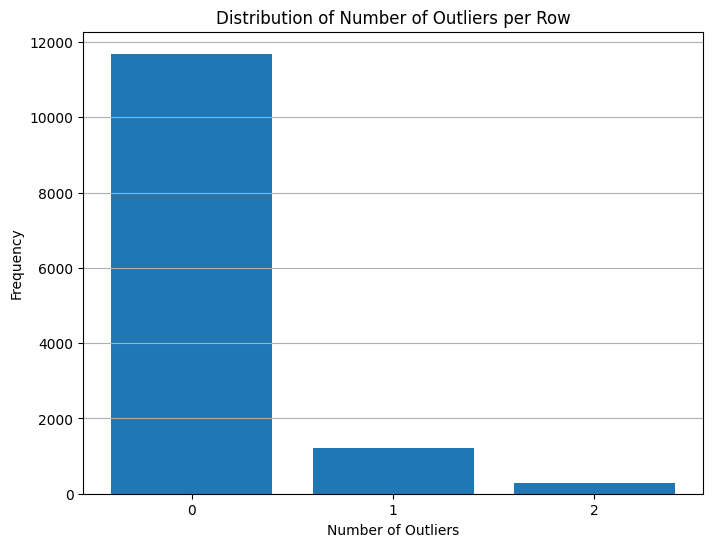

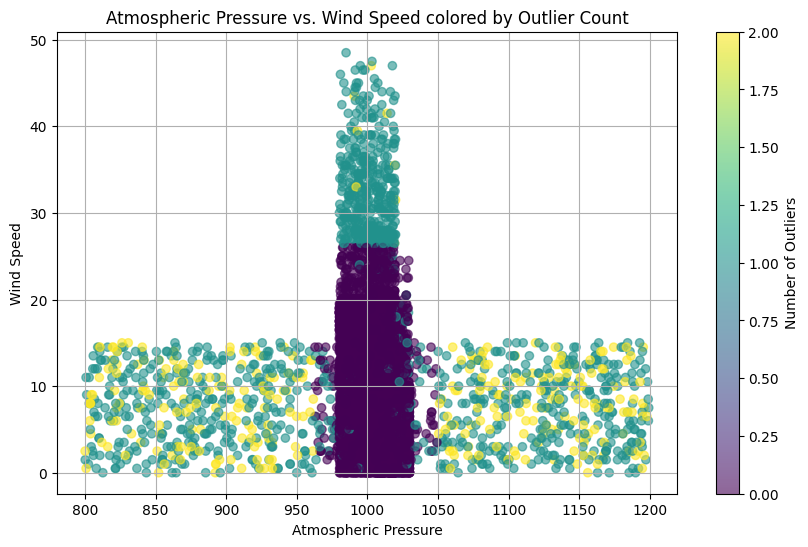

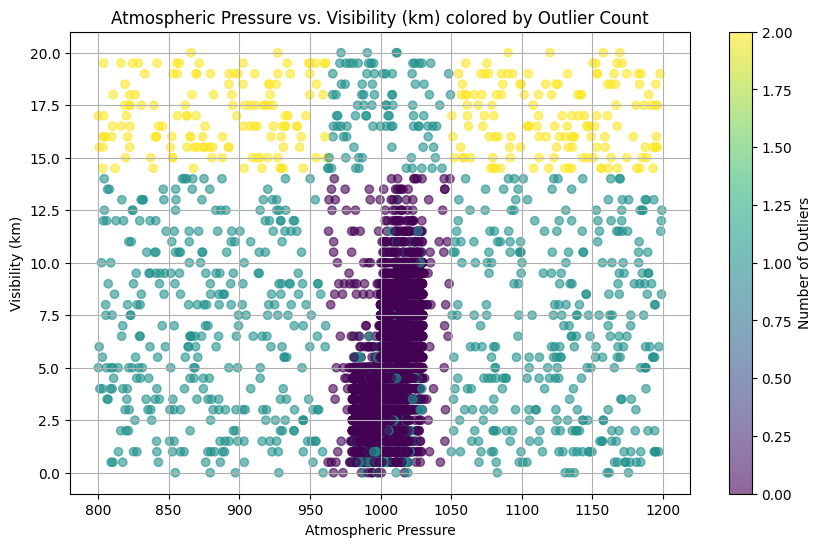

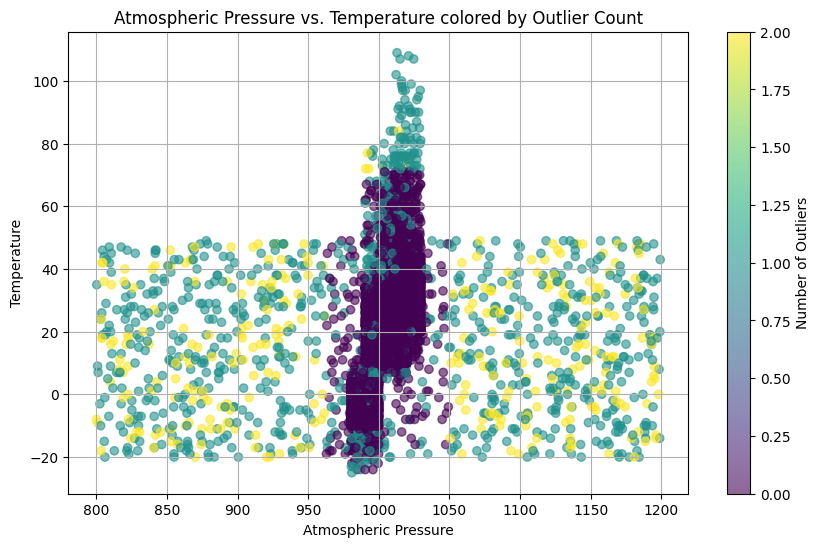

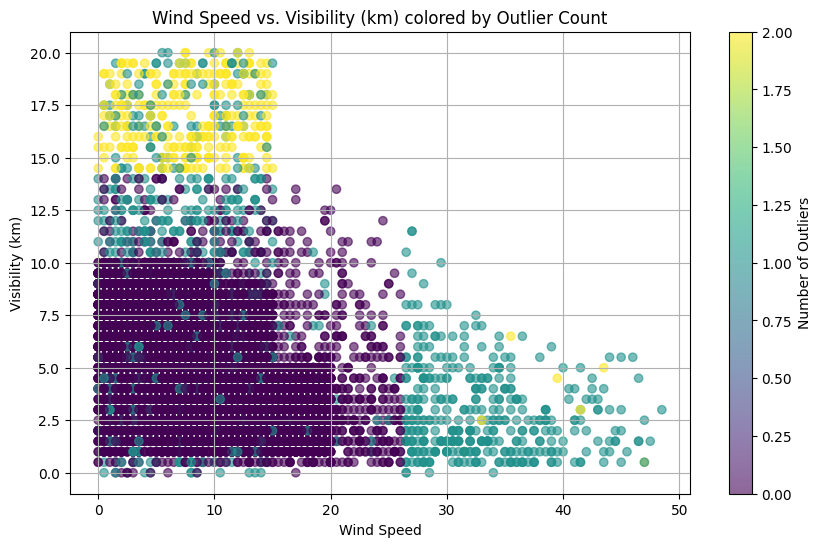

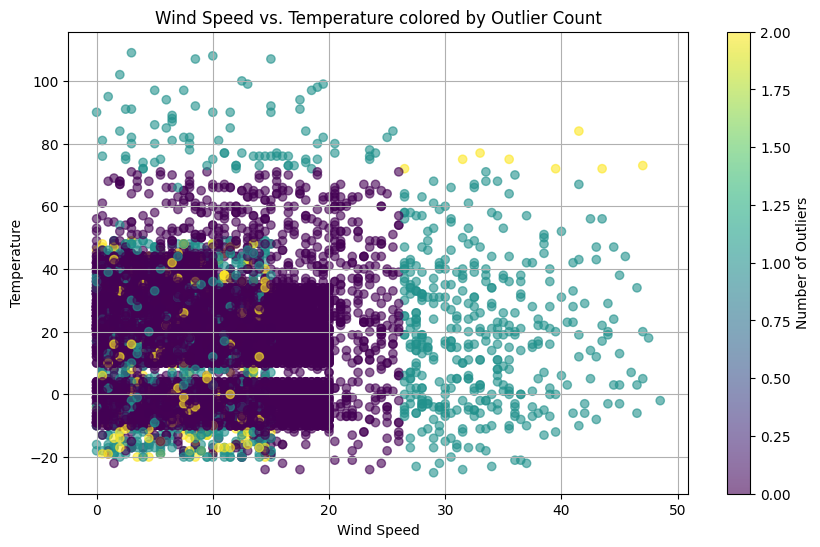

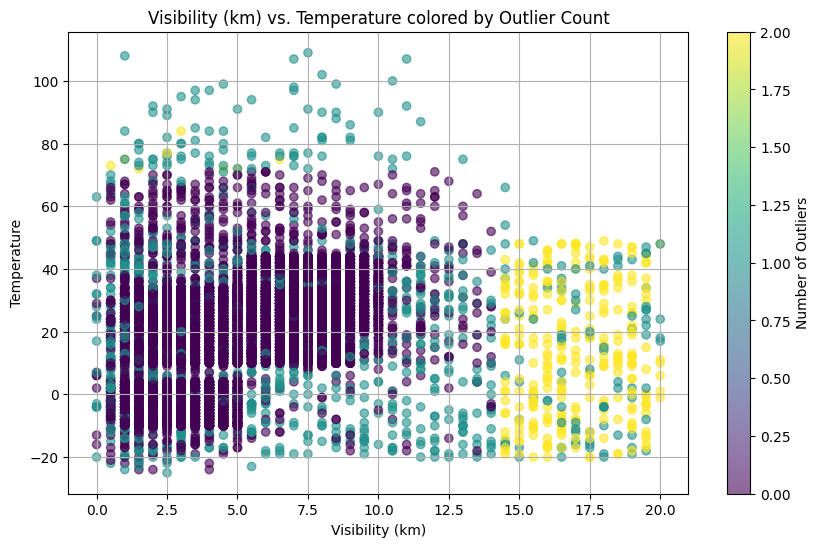

In [14]:
# Create a scatter plot of Temperature vs Atmospheric Pressure, colored by CANT_OUT
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(wh['Temperature'], wh['Atmospheric Pressure'], c=wh['CANT_OUT'], cmap='viridis', alpha=0.6)
# plt.title('Temperature vs. Atmospheric Pressure colored by Outlier Count')
# plt.xlabel('Temperature')
# plt.ylabel('Atmospheric Pressure')
# plt.colorbar(scatter, label='Number of Outliers')
# plt.grid(True)
# plt.show()

# Create a histogram of the CANT_OUT column
plt.figure(figsize=(8, 6))
plt.hist(wh['CANT_OUT'], bins=range(wh['CANT_OUT'].max() + 2), align='left', rwidth=0.8)
plt.title('Distribution of Number of Outliers per Row')
plt.xlabel('Number of Outliers')
plt.ylabel('Frequency')
plt.xticks(range(wh['CANT_OUT'].max() + 1))
plt.grid(axis='y')
plt.show()

# Identify the top 4 columns with the most outliers
top_outlier_cols = total_outliers_per_column.sort_values(ascending=False).head(4).index.tolist()

# Create scatter plots for all pairs of the top outlier columns
for i in range(len(top_outlier_cols)):
    for j in range(i + 1, len(top_outlier_cols)):
        col1 = top_outlier_cols[i]
        col2 = top_outlier_cols[j]

        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(wh[col1], wh[col2], c=wh['CANT_OUT'], cmap='viridis', alpha=0.6)
        plt.title(f'{col1} vs. {col2} colored by Outlier Count')
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.colorbar(scatter, label='Number of Outliers')
        plt.grid(True)
        plt.show()

## 3 - Discretizacion

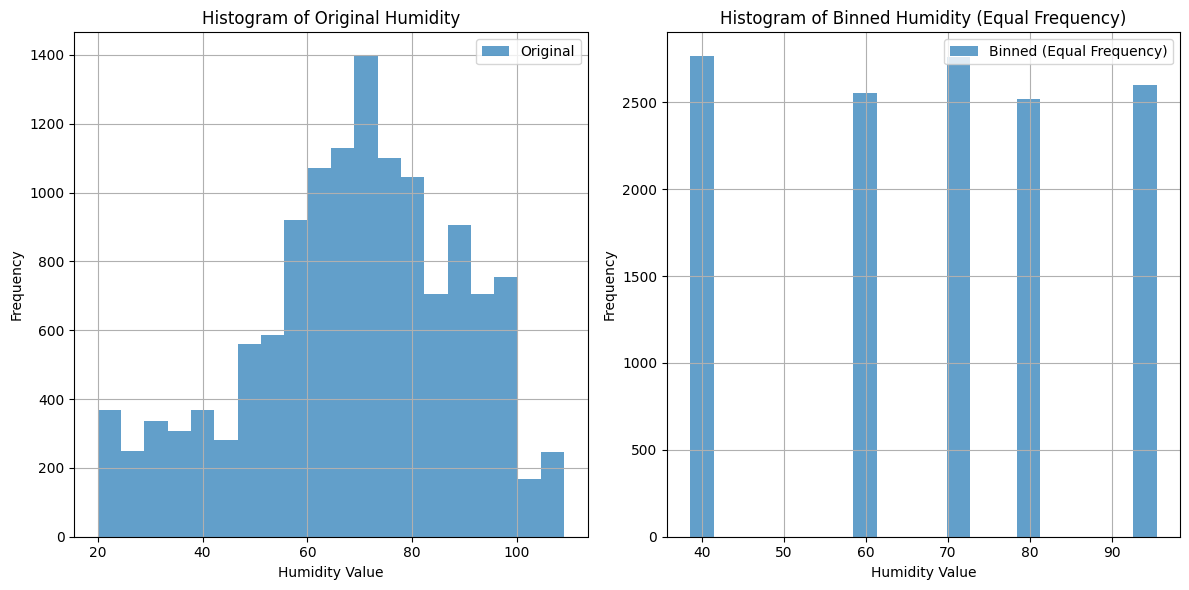

In [15]:
# Function to perform equal frequency binning and calculate bin means
def equal_frequency_binning(data, num_bins):
    # Create bins based on quantiles
    bins = pd.qcut(data, q=num_bins, labels=False, duplicates='drop')

    # Calculate the mean for each bin
    bin_means = data.groupby(bins).mean()

    # Map the bin means back to the original data
    binned_data = bins.map(bin_means)

    return binned_data

# Apply equal frequency binning to the 'Humidity' column with 5 bins
humidity_binned = equal_frequency_binning(wh['Humidity'], 5)

# Plot histograms of the original and binned data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(wh['Humidity'], bins=20, alpha=0.7, label='Original')
plt.title('Histogram of Original Humidity')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(humidity_binned, bins=20, alpha=0.7, label='Binned (Equal Frequency)')
plt.title('Histogram of Binned Humidity (Equal Frequency)')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

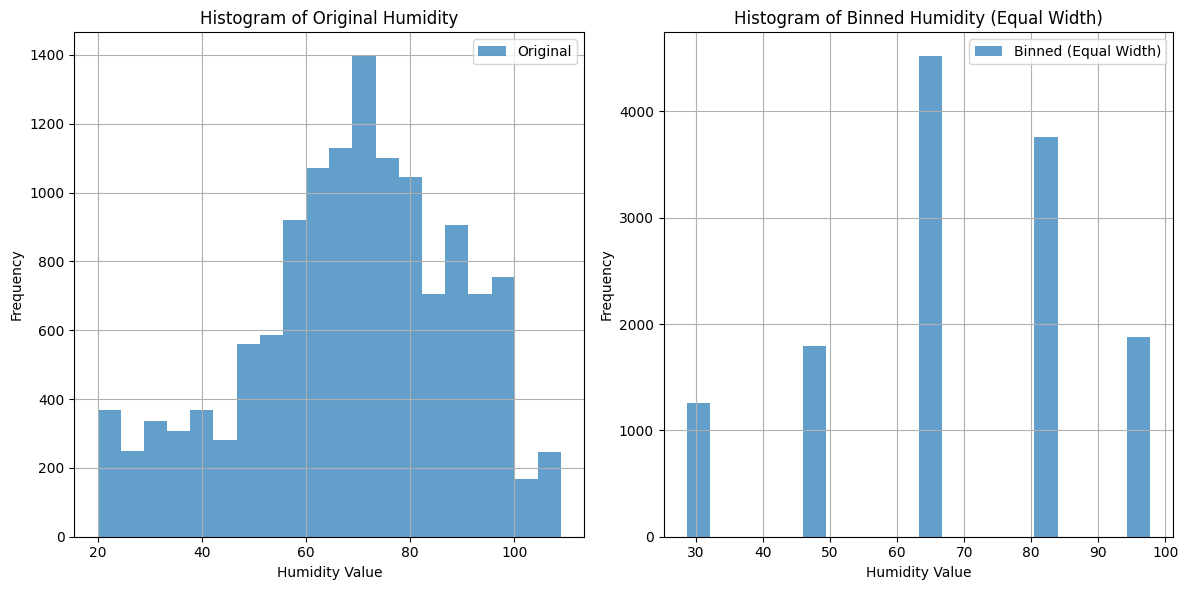

In [16]:
# Function to perform equal width binning
def equal_width_binning(data, num_bins):
    # Create bins with equal width
    bins = pd.cut(data, bins=num_bins, labels=False, include_lowest=True)

    # Calculate the mean for each bin
    bin_means = data.groupby(bins).mean()

    # Map the bin means back to the original data
    binned_data = bins.map(bin_means)

    return binned_data

# Apply equal width binning to the 'Humidity' column with 5 bins
humidity_binned_equal_width = equal_width_binning(wh['Humidity'], 5)

# Plot histograms of the original and binned data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(wh['Humidity'], bins=20, alpha=0.7, label='Original')
plt.title('Histogram of Original Humidity')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(humidity_binned_equal_width, bins=20, alpha=0.7, label='Binned (Equal Width)')
plt.title('Histogram of Binned Humidity (Equal Width)')
plt.xlabel('Humidity Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 4 - Normalizacion

 Para el siguiente dominio:  
E = {1, 5, 9, 17, 18, 34, 45, 89, 99}  
¿Cuál sería el valor de escalado decimal para 65?: seria 0,65, ya que el dominio tiene 2 decimales

¿Y si utilizo mínimo-máximo?: es 64/98

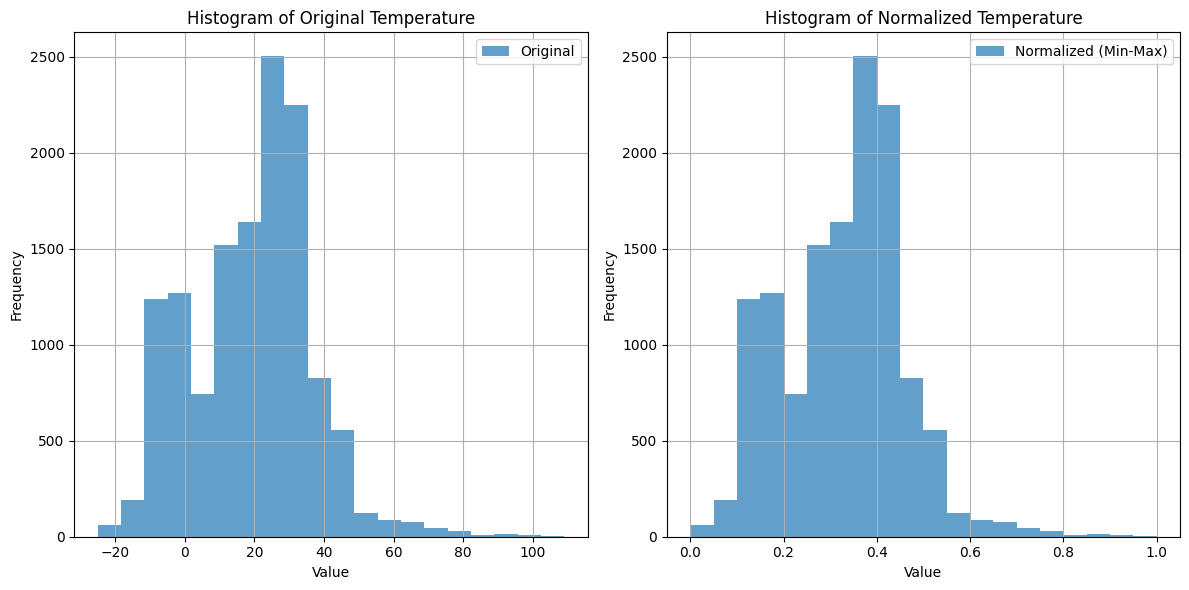

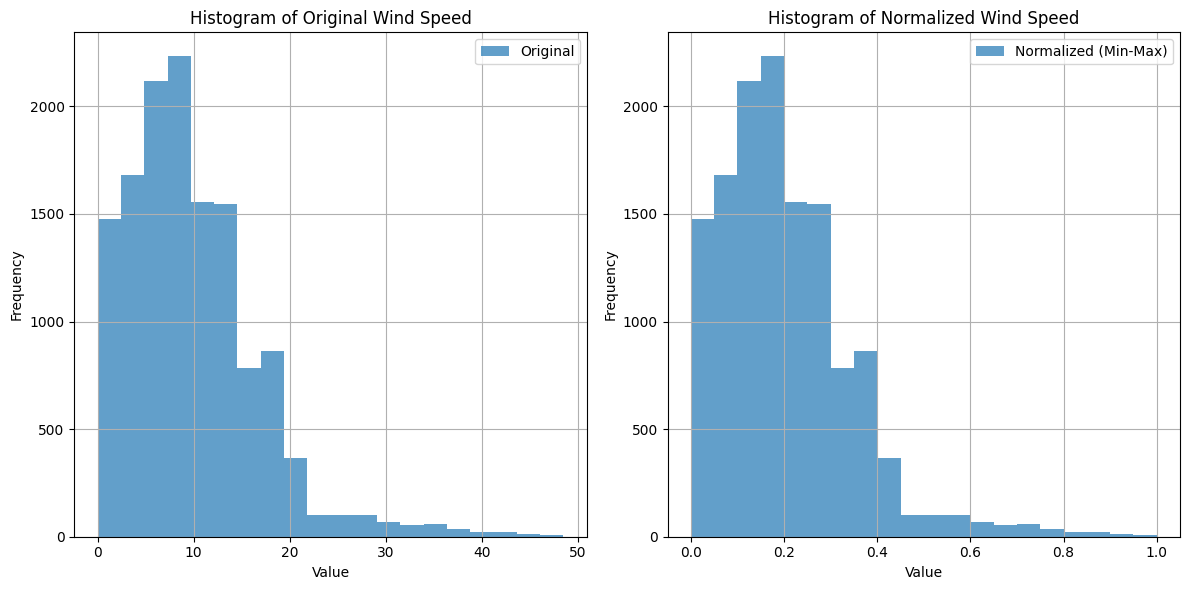

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the columns to normalize
columns_to_normalize = ['Temperature', 'Wind Speed']

# Apply min-max normalization
wh_normalized = wh.copy() # Create a copy to avoid modifying the original DataFrame
wh_normalized[columns_to_normalize] = scaler.fit_transform(wh[columns_to_normalize])

# Plot histograms of the original and normalized data
for col in columns_to_normalize:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(wh[col], bins=20, alpha=0.7, label='Original')
    plt.title(f'Histogram of Original {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(wh_normalized[col], bins=20, alpha=0.7, label='Normalized (Min-Max)')
    plt.title(f'Histogram of Normalized {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

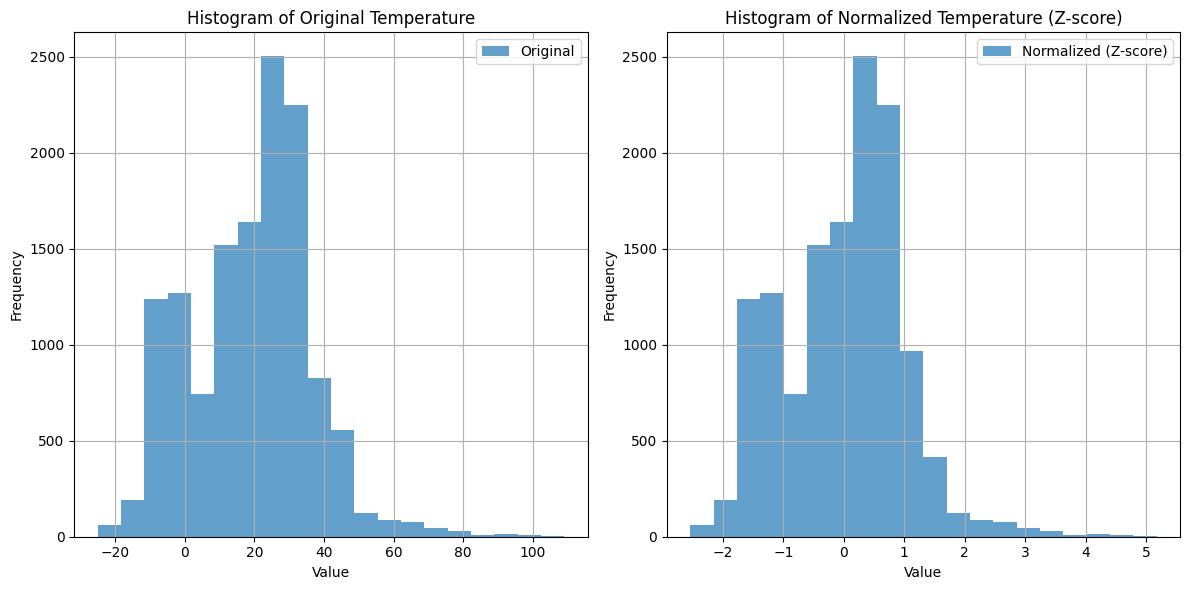

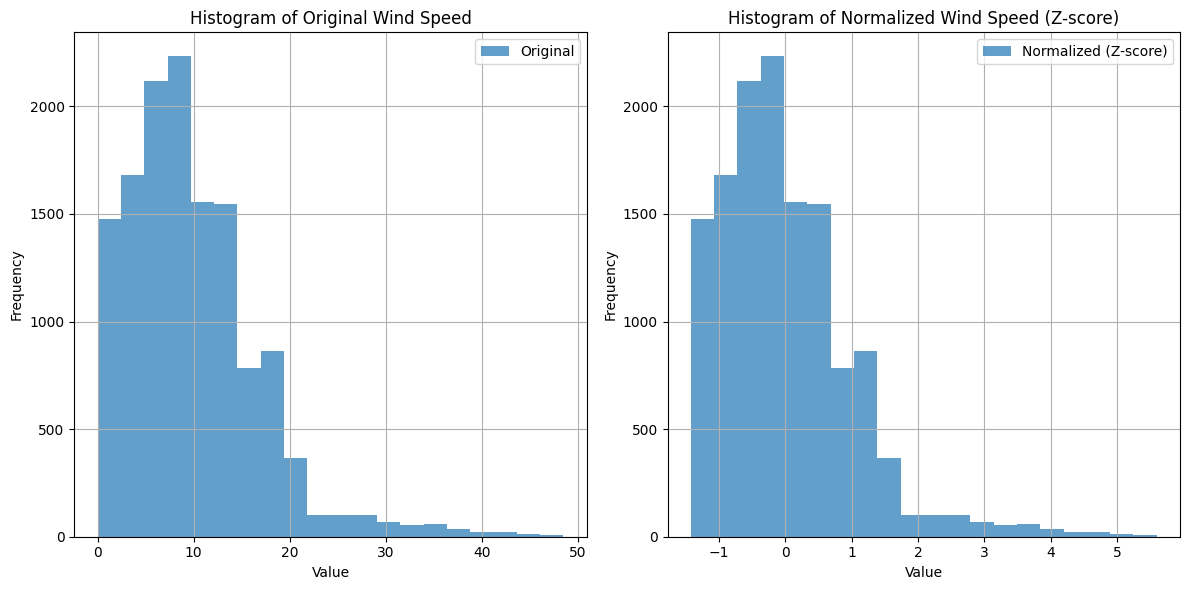

In [18]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler_zscore = StandardScaler()

# Select the columns to normalize
columns_to_normalize = ['Temperature', 'Wind Speed']

# Apply z-score normalization
wh_normalized_zscore = wh.copy() # Create a copy to avoid modifying the original DataFrame
wh_normalized_zscore[columns_to_normalize] = scaler_zscore.fit_transform(wh[columns_to_normalize])

# Plot histograms of the original and normalized data
for col in columns_to_normalize:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(wh[col], bins=20, alpha=0.7, label='Original')
    plt.title(f'Histogram of Original {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(wh_normalized_zscore[col], bins=20, alpha=0.7, label='Normalized (Z-score)')
    plt.title(f'Histogram of Normalized {col} (Z-score)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

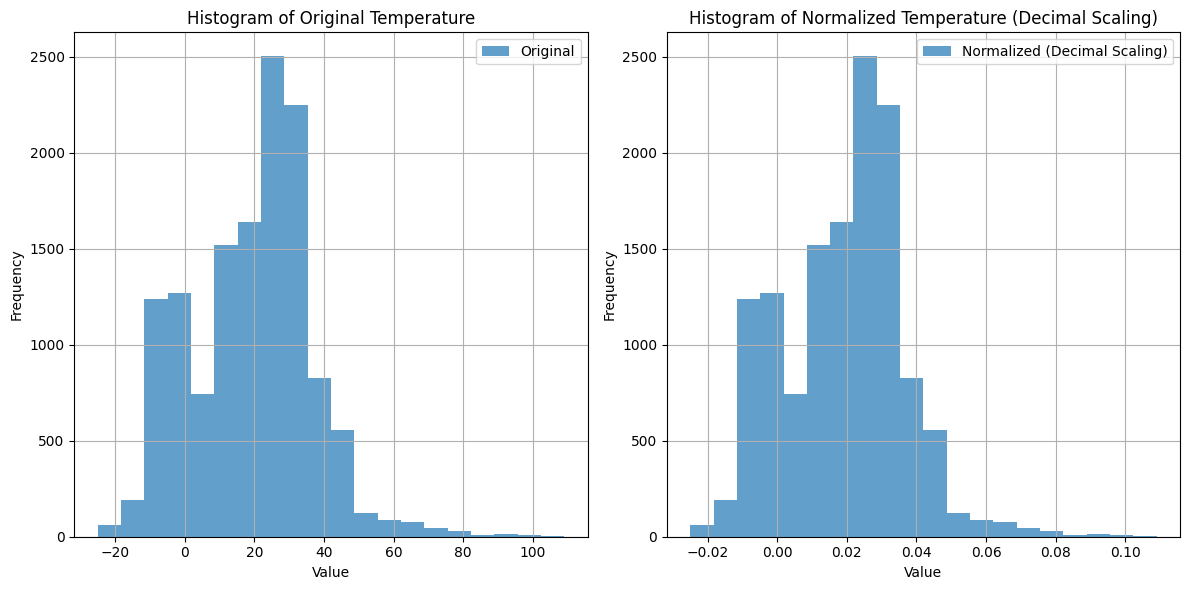

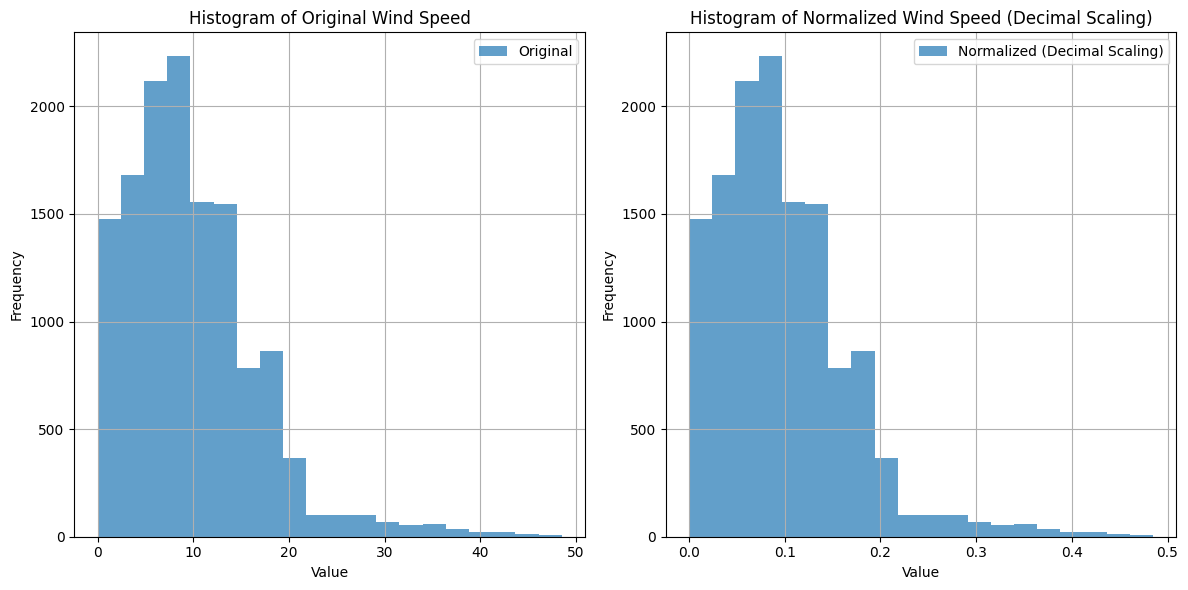

In [19]:
def decimal_scaling(data):
    # Find the maximum absolute value in the data
    max_abs = np.max(np.abs(data))

    # Determine the scaling factor
    scale_factor = 10**(np.ceil(np.log10(max_abs)))

    # Apply decimal scaling
    scaled_data = data / scale_factor
    return scaled_data

# Select the columns to normalize
columns_to_normalize = ['Temperature', 'Wind Speed']

# Apply decimal scaling
wh_normalized_decimal = wh.copy() # Create a copy to avoid modifying the original DataFrame
for col in columns_to_normalize:
    wh_normalized_decimal[col] = decimal_scaling(wh[col])

# Plot histograms of the original and normalized data
for col in columns_to_normalize:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(wh[col], bins=20, alpha=0.7, label='Original')
    plt.title(f'Histogram of Original {col}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(wh_normalized_decimal[col], bins=20, alpha=0.7, label='Normalized (Decimal Scaling)')
    plt.title(f'Histogram of Normalized {col} (Decimal Scaling)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

### Boxplots of Min-Max Normalized Data by Season

<Figure size 1000x600 with 0 Axes>

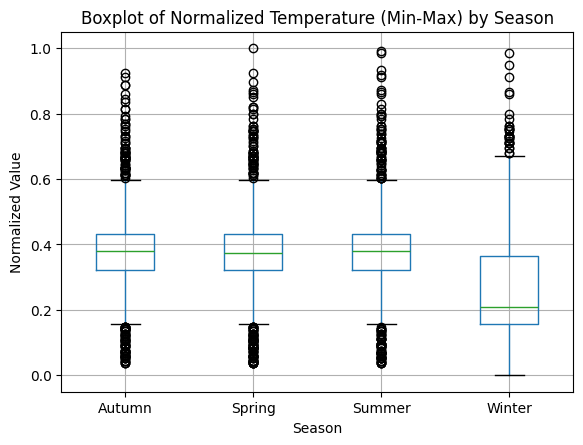

<Figure size 1000x600 with 0 Axes>

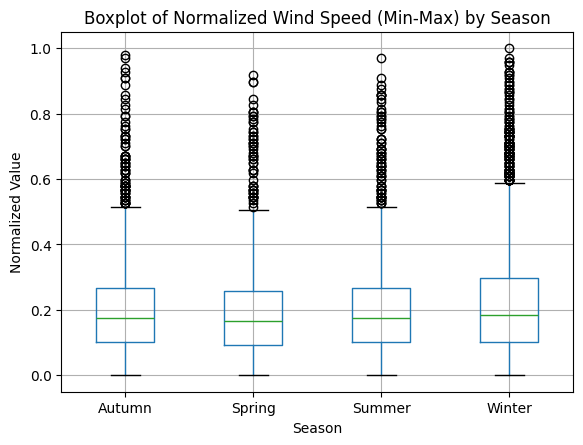

In [20]:
# Select numerical columns that were normalized using Min-Max
columns_normalized_minmax = ['Temperature', 'Wind Speed']

# Create boxplots for each min-max normalized column, grouped by 'Season'
for col in columns_normalized_minmax:
    plt.figure(figsize=(10, 6))
    wh_normalized.boxplot(column=col, by='Season')
    plt.title(f'Boxplot of Normalized {col} (Min-Max) by Season')
    plt.suptitle('') # Suppress the default suptitle generated by boxplot
    plt.ylabel('Normalized Value')
    plt.show()

### Boxplots of Z-score Normalized Data by Season

<Figure size 1000x600 with 0 Axes>

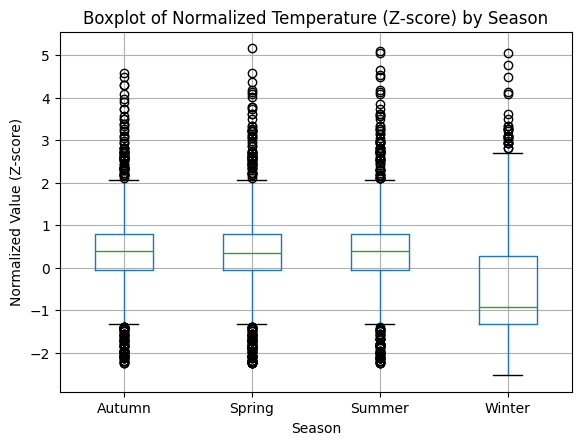

<Figure size 1000x600 with 0 Axes>

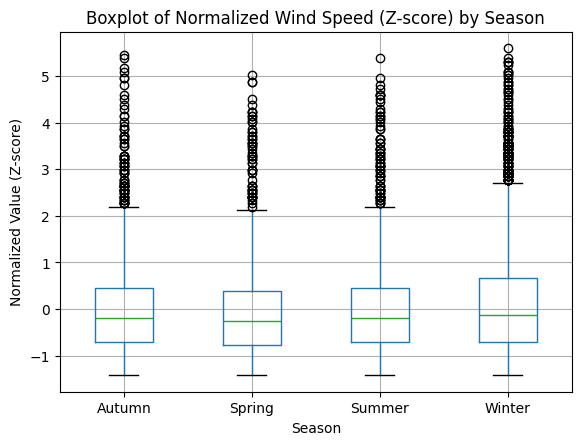

In [21]:
# Select numerical columns that were normalized using Z-score
columns_normalized_zscore = ['Temperature', 'Wind Speed']

# Create boxplots for each z-score normalized column, grouped by 'Season'
for col in columns_normalized_zscore:
    plt.figure(figsize=(10, 6))
    wh_normalized_zscore.boxplot(column=col, by='Season')
    plt.title(f'Boxplot of Normalized {col} (Z-score) by Season')
    plt.suptitle('') # Suppress the default suptitle generated by boxplot
    plt.ylabel('Normalized Value (Z-score)')
    plt.show()

### Boxplots of Decimal Scaled Data by Season

<Figure size 1000x600 with 0 Axes>

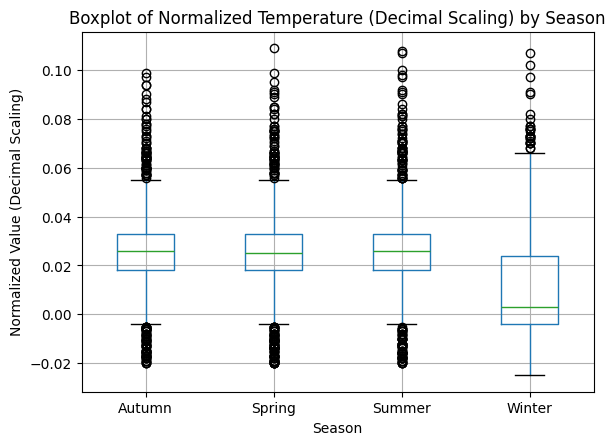

<Figure size 1000x600 with 0 Axes>

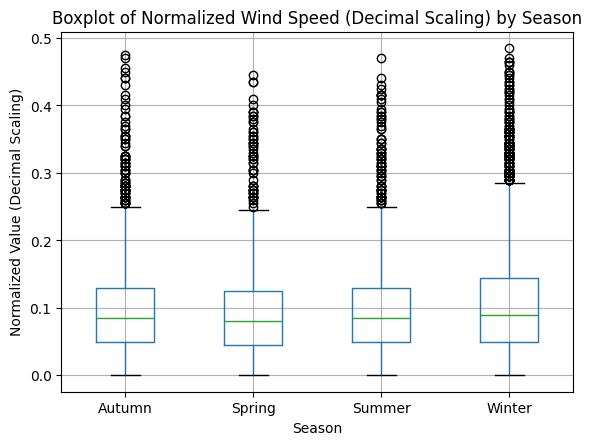

In [22]:
# Select numerical columns that were normalized using Decimal Scaling
columns_normalized_decimal = ['Temperature', 'Wind Speed']

# Create boxplots for each decimal scaled column, grouped by 'Season'
for col in columns_normalized_decimal:
    plt.figure(figsize=(10, 6))
    wh_normalized_decimal.boxplot(column=col, by='Season')
    plt.title(f'Boxplot of Normalized {col} (Decimal Scaling) by Season')
    plt.suptitle('') # Suppress the default suptitle generated by boxplot
    plt.ylabel('Normalized Value (Decimal Scaling)')
    plt.show()

# PARTE 2

## 5 - Datos faltantes

In [23]:
car = pd.read_csv('https://raw.githubusercontent.com/bdm-unlu/2025/main/TPs/TP01/car_ad.csv', encoding='latin-1') # Added encoding
# car.describe( include= "all")
car.head()

car    price       body  mileage  engV engType registration  \
0           Ford  15500.0  crossover       68   2.5     Gas          yes   
1  Mercedes-Benz  20500.0      sedan      173   1.8     Gas          yes   
2  Mercedes-Benz  35000.0      other      135   5.5  Petrol          yes   
3  Mercedes-Benz  17800.0        van      162   1.8  Diesel          yes   
4  Mercedes-Benz  33000.0      vagon       91   NaN   Other          yes   

   year    model  drive  
0  2010     Kuga   full  
1  2011  E-Class   rear  
2  2008   CL 550   rear  
3  2012    B 180  front  
4  2013  E-Class    NaN

<Axes: >

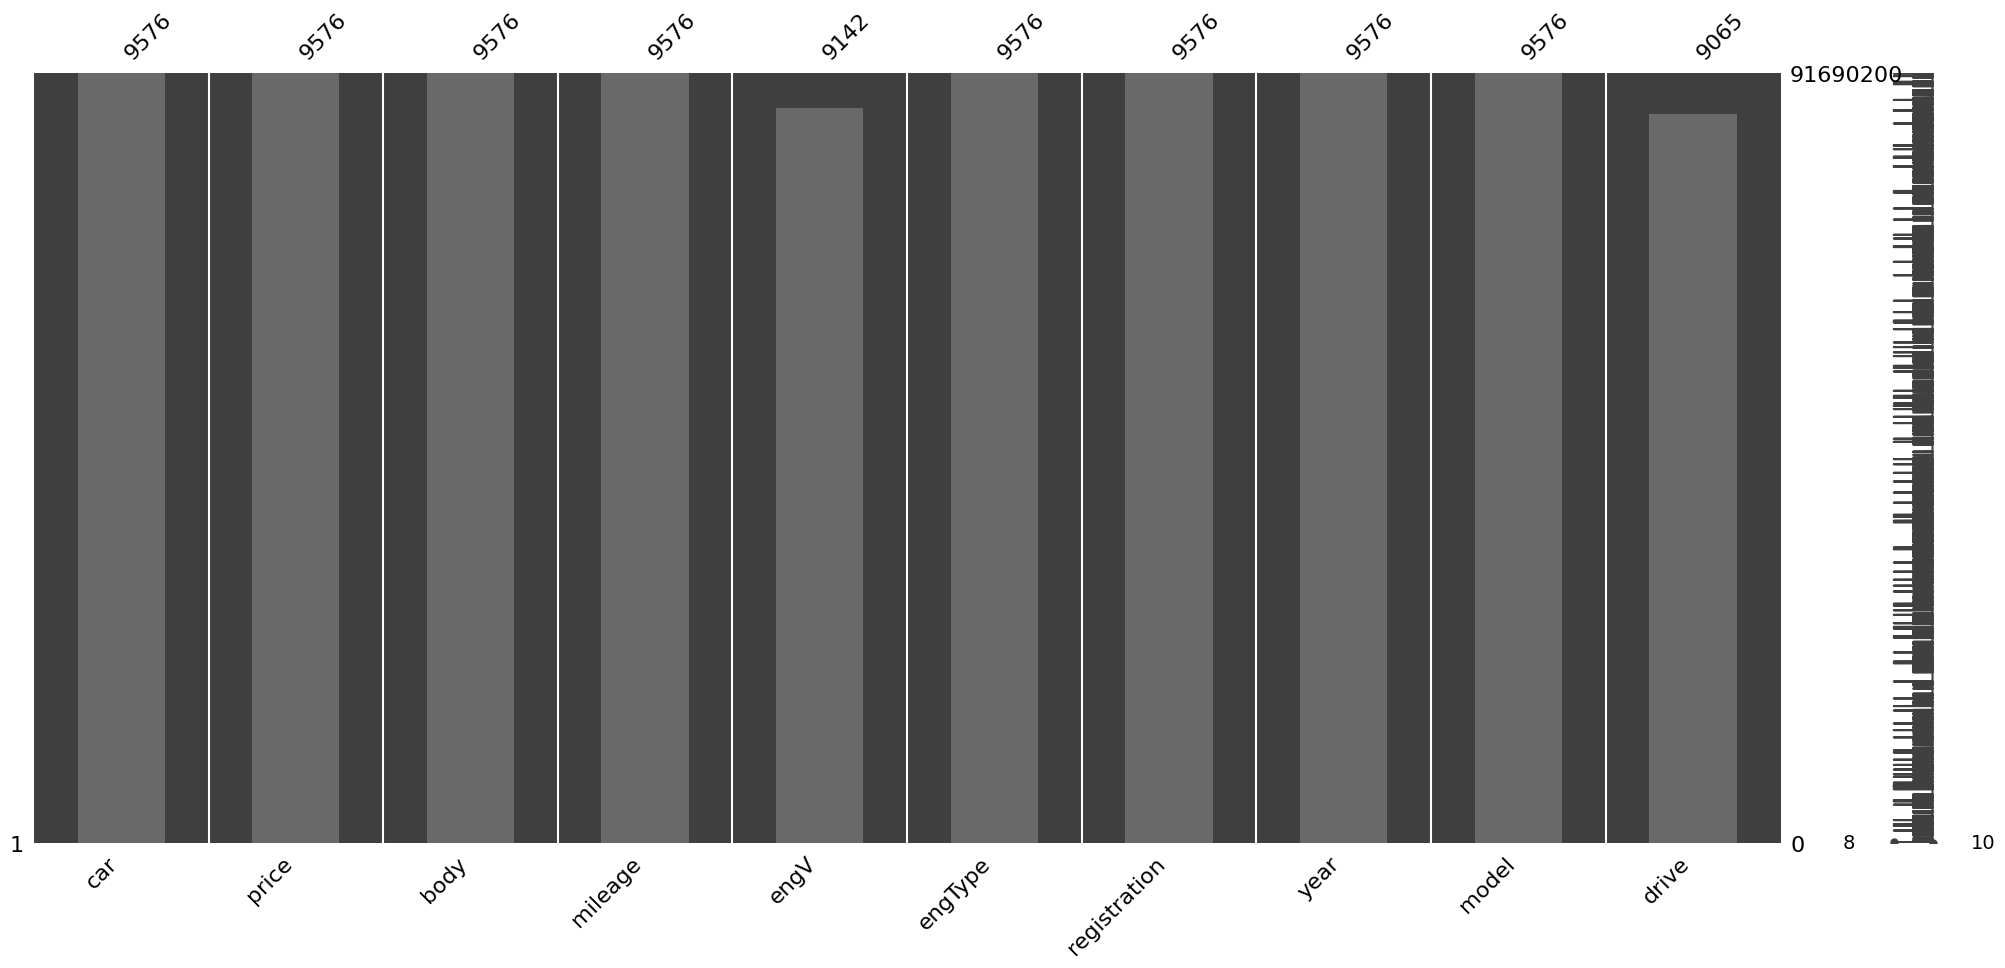

In [24]:
!pip install missingno
import missingno as msno

msno.matrix(car)
msno.bar(car)

Columns with missing values: ['engV', 'drive']
Filled missing values in 'engV' with mean: 2.65
Filled missing values in 'drive' with mode: front

Missing values after imputation in the copied DataFrame:
car             0
price           0
body            0
mileage         0
engV            0
engType         0
registration    0
year            0
model           0
drive           0
dtype: int64


/tmp/ipython-input-3411115929.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  car_cleaned[col].fillna(mean_value, inplace=True)
/tmp/ipython-input-3411115929.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

<Axes: >

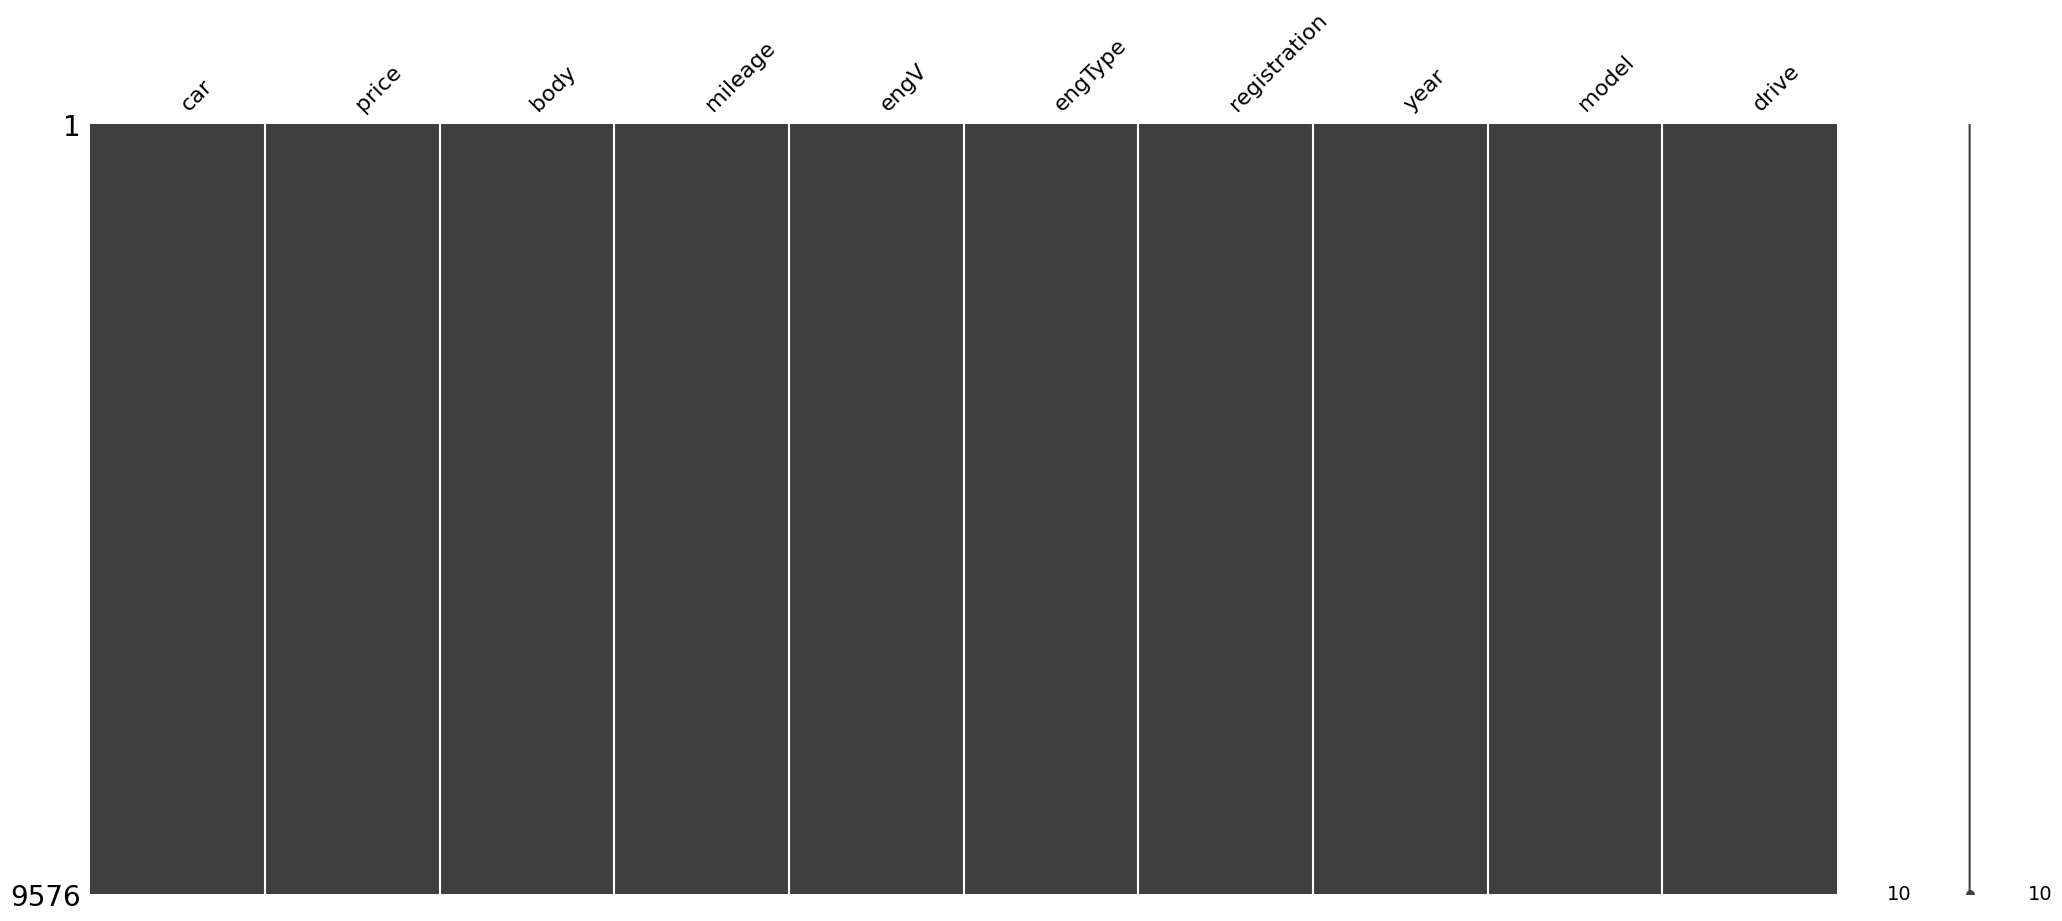

In [25]:
# Identify columns with missing values
missing_cols = car.columns[car.isnull().any()].tolist()

print("Columns with missing values:", missing_cols)

# Create a copy of the DataFrame to avoid modifying the original
car_cleaned = car.copy()

# Impute missing values
for col in missing_cols:
    if car_cleaned[col].dtype == 'object': # Categorical column
        # Impute with mode
        mode_value = car_cleaned[col].mode()[0] # mode() can return multiple values, take the first
        car_cleaned[col].fillna(mode_value, inplace=True)
        print(f"Filled missing values in '{col}' with mode: {mode_value}")
    else: # Numerical column
        # Impute with mean
        mean_value = car_cleaned[col].mean()
        car_cleaned[col].fillna(mean_value, inplace=True)
        print(f"Filled missing values in '{col}' with mean: {mean_value:.2f}")

# Verify that there are no more missing values in the copied DataFrame
print("\nMissing values after imputation in the copied DataFrame:")
print(car_cleaned.isnull().sum())

# Visualize the missing data again in the copied DataFrame
msno.matrix(car_cleaned)

In [26]:
from sklearn.impute import KNNImputer

# Create a copy of the DataFrame to avoid modifying the original
car_imputed_knn = car.copy()

# Select only numerical columns for KNN imputation
numerical_cols = car_imputed_knn.select_dtypes(include=np.number).columns

# Initialize KNNImputer (you can adjust the number of neighbors 'n_neighbors')
imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation to the numerical columns
car_imputed_knn[numerical_cols] = imputer.fit_transform(car_imputed_knn[numerical_cols])

# Display the head of the DataFrame with imputed values
print("DataFrame after KNN Imputation:")
display(car_imputed_knn.head())

# Verify that there are no more missing values in the imputed DataFrame
print("\nMissing values after KNN imputation:")
print(car_imputed_knn.isnull().sum())

DataFrame after KNN Imputation:


car    price       body  mileage  engV engType registration  \
0           Ford  15500.0  crossover     68.0  2.50     Gas          yes   
1  Mercedes-Benz  20500.0      sedan    173.0  1.80     Gas          yes   
2  Mercedes-Benz  35000.0      other    135.0  5.50  Petrol          yes   
3  Mercedes-Benz  17800.0        van    162.0  1.80  Diesel          yes   
4  Mercedes-Benz  33000.0      vagon     91.0  3.18   Other          yes   

     year    model  drive  
0  2010.0     Kuga   full  
1  2011.0  E-Class   rear  
2  2008.0   CL 550   rear  
3  2012.0    B 180  front  
4  2013.0  E-Class    NaN


Missing values after KNN imputation:
car               0
price             0
body              0
mileage           0
engV              0
engType           0
registration      0
year              0
model             0
drive           511
dtype: int64


Tomando solo 1 neighbourgh, genero el algoritmo como lo vimos en clase, sin potenciales valores que se salgan del dominio, producto de promediar valores.

In [27]:
from sklearn.impute import KNNImputer

# Create a copy of the DataFrame to avoid modifying the original
car_imputed_knn = car.copy()

# Select only numerical columns for KNN imputation
numerical_cols = car_imputed_knn.select_dtypes(include=np.number).columns

# Initialize KNNImputer (you can adjust the number of neighbors 'n_neighbors')
imputer = KNNImputer(n_neighbors=1)

# Apply KNN imputation to the numerical columns
car_imputed_knn[numerical_cols] = imputer.fit_transform(car_imputed_knn[numerical_cols])

# Display the head of the DataFrame with imputed values
print("DataFrame after KNN Imputation:")
display(car_imputed_knn.head())

# Verify that there are no more missing values in the imputed DataFrame
print("\nMissing values after KNN imputation:")
print(car_imputed_knn.isnull().sum())

DataFrame after KNN Imputation:


car    price       body  mileage  engV engType registration  \
0           Ford  15500.0  crossover     68.0   2.5     Gas          yes   
1  Mercedes-Benz  20500.0      sedan    173.0   1.8     Gas          yes   
2  Mercedes-Benz  35000.0      other    135.0   5.5  Petrol          yes   
3  Mercedes-Benz  17800.0        van    162.0   1.8  Diesel          yes   
4  Mercedes-Benz  33000.0      vagon     91.0   3.7   Other          yes   

     year    model  drive  
0  2010.0     Kuga   full  
1  2011.0  E-Class   rear  
2  2008.0   CL 550   rear  
3  2012.0    B 180  front  
4  2013.0  E-Class    NaN


Missing values after KNN imputation:
car               0
price             0
body              0
mileage           0
engV              0
engType           0
registration      0
year              0
model             0
drive           511
dtype: int64


In [28]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np # Import numpy

# Create a copy of the DataFrame to avoid modifying the original
car_imputed_regression = car.copy()

# Select only numerical columns for regression imputation
numerical_cols = car_imputed_regression.select_dtypes(include=np.number).columns

# Initialize IterativeImputer (using a BayesianRidge model by default, suitable for regression)
# max_iter is the number of imputation rounds
imputer = IterativeImputer(max_iter=10, random_state=0)

# Apply IterativeImputer to the numerical columns
# IterativeImputer returns a NumPy array, so we need to convert it back to a DataFrame
car_imputed_regression[numerical_cols] = imputer.fit_transform(car_imputed_regression[numerical_cols])

# Display the head of the DataFrame with imputed values
print("DataFrame after Regression Imputation:")
display(car_imputed_regression.head())

# Verify that there are no more missing values in the imputed DataFrame
print("\nMissing values after Regression Imputation:")
print(car_imputed_regression.isnull().sum())

DataFrame after Regression Imputation:


car    price       body  mileage      engV engType registration  \
0           Ford  15500.0  crossover     68.0  2.500000     Gas          yes   
1  Mercedes-Benz  20500.0      sedan    173.0  1.800000     Gas          yes   
2  Mercedes-Benz  35000.0      other    135.0  5.500000  Petrol          yes   
3  Mercedes-Benz  17800.0        van    162.0  1.800000  Diesel          yes   
4  Mercedes-Benz  33000.0      vagon     91.0  2.634229   Other          yes   

     year    model  drive  
0  2010.0     Kuga   full  
1  2011.0  E-Class   rear  
2  2008.0   CL 550   rear  
3  2012.0    B 180  front  
4  2013.0  E-Class    NaN


Missing values after Regression Imputation:
car               0
price             0
body              0
mileage           0
engV              0
engType           0
registration      0
year              0
model             0
drive           511
dtype: int64


### Comparison of 'engV' Distribution After Different Imputation Methods

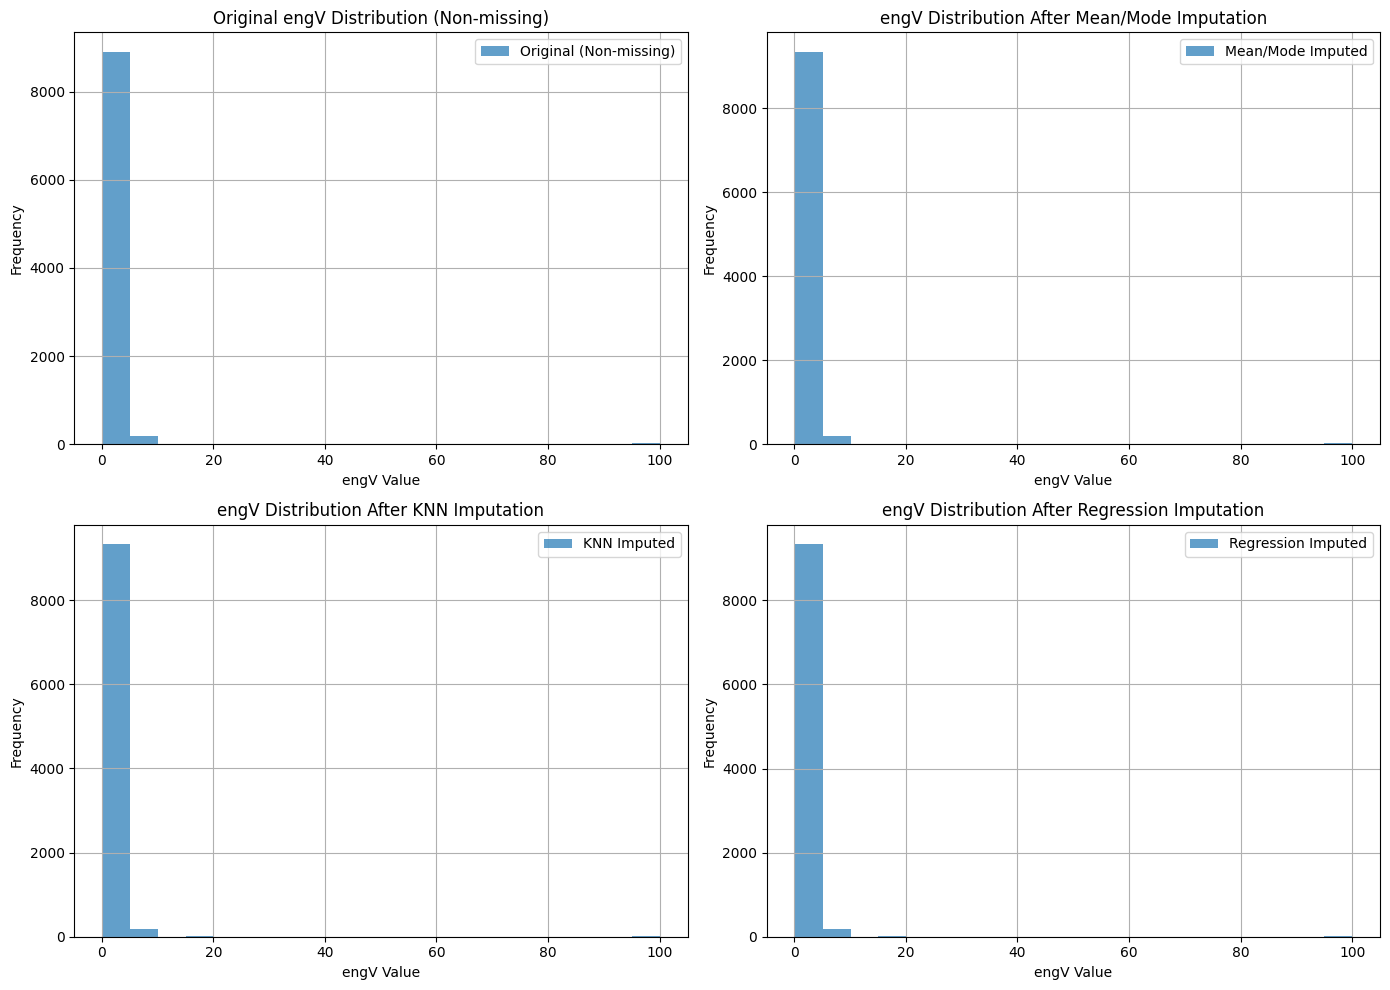

In [29]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the original 'engV' distribution
axes[0].hist(car['engV'].dropna(), bins=20, alpha=0.7, label='Original (Non-missing)')
axes[0].set_title('Original engV Distribution (Non-missing)')
axes[0].set_xlabel('engV Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)
axes[0].legend()

# Plot the 'engV' distribution after Mean/Mode Imputation
axes[1].hist(car_cleaned['engV'], bins=20, alpha=0.7, label='Mean/Mode Imputed')
axes[1].set_title('engV Distribution After Mean/Mode Imputation')
axes[1].set_xlabel('engV Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)
axes[1].legend()


# Plot the 'engV' distribution after KNN Imputation
axes[2].hist(car_imputed_knn['engV'], bins=20, alpha=0.7, label='KNN Imputed')
axes[2].set_title('engV Distribution After KNN Imputation')
axes[2].set_xlabel('engV Value')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)
axes[2].legend()

# Plot the 'engV' distribution after Regression Imputation
axes[3].hist(car_imputed_regression['engV'], bins=20, alpha=0.7, label='Regression Imputed')
axes[3].set_title('engV Distribution After Regression Imputation')
axes[3].set_xlabel('engV Value')
axes[3].set_ylabel('Frequency')
axes[3].grid(True)
axes[3].legend()

plt.tight_layout()
plt.show()

Comparison of Imputed 'engV' Values for Originally Missing Data:


Original (NaN)  Mean/Mode Imputed  KNN Imputed  Regression Imputed
4                NaN           2.646344          3.7            2.634229
13               NaN           2.646344          2.5            2.959952
30               NaN           2.646344          2.5            2.054982
31               NaN           2.646344          1.7            2.099176
37               NaN           2.646344          1.5            3.022458
...              ...                ...          ...                 ...
9470             NaN           2.646344          1.5            2.699259
9480             NaN           2.646344          1.8            2.434427
9515             NaN           2.646344          1.6            2.484466
9546             NaN           2.646344          1.4            2.553895
9566             NaN           2.646344          1.1            3.539426

[434 rows x 4 columns]

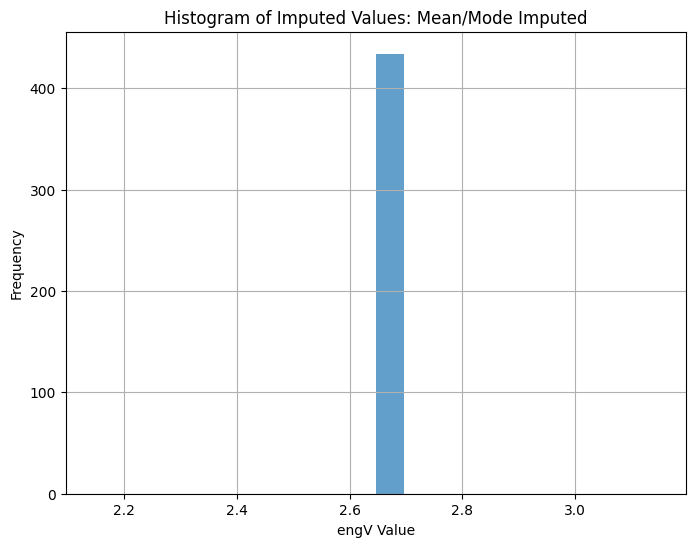

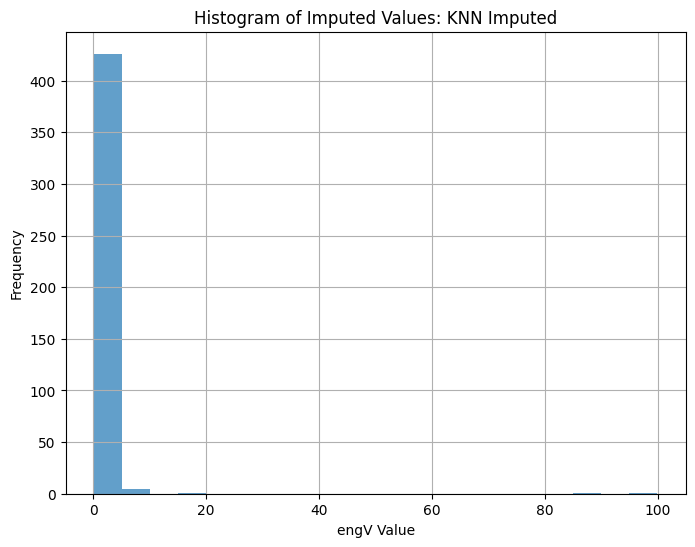

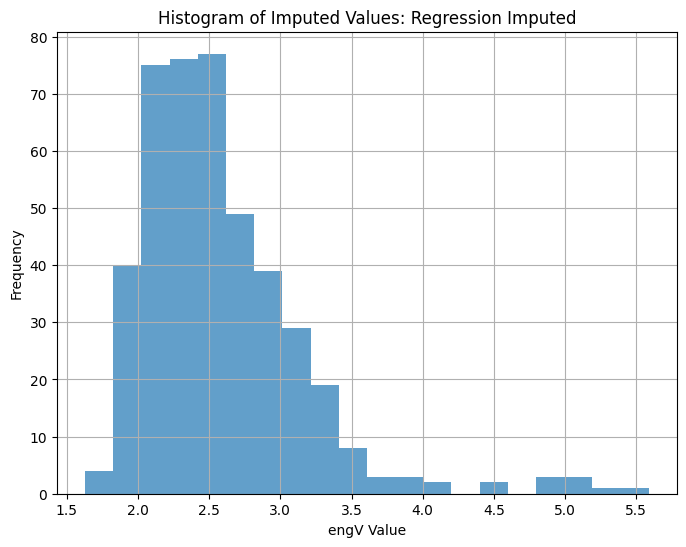

In [30]:
# Identify the indices where 'engV' was originally missing
missing_engV_indices = car[car['engV'].isnull()].index

# Create a DataFrame to compare the imputed values at these indices
comparison_df = pd.DataFrame({
    'Original (NaN)': car.loc[missing_engV_indices, 'engV'],
    'Mean/Mode Imputed': car_cleaned.loc[missing_engV_indices, 'engV'],
    'KNN Imputed': car_imputed_knn.loc[missing_engV_indices, 'engV'],
    'Regression Imputed': car_imputed_regression.loc[missing_engV_indices, 'engV']
})

# Display the comparison table
print("Comparison of Imputed 'engV' Values for Originally Missing Data:")
display(comparison_df)

# Plot histograms for each column in the comparison DataFrame
for col in comparison_df.columns:
    if col != 'Original (NaN)': # No point in plotting a histogram of all NaNs
        plt.figure(figsize=(8, 6))
        plt.hist(comparison_df[col].dropna(), bins=20, alpha=0.7)
        plt.title(f'Histogram of Imputed Values: {col}')
        plt.xlabel('engV Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

## 6 - Analisis de componentes principales

In [31]:
# aut = pd.read_csv('https://raw.githubusercontent.com/bdm-unlu/2025/main/TPs/TP01/aut.csv', encoding='latin-1') # Added encoding
aut = pd.read_csv('https://raw.githubusercontent.com/bdm-unlu/2025/main/TPs/TP01/Automobile.csv')
aut.describe()

mpg   cylinders  displacement  horsepower       weight  \
count  398.000000  398.000000    398.000000  392.000000   398.000000   
mean    23.514573    5.454774    193.425879  104.469388  2970.424623   
std      7.815984    1.701004    104.269838   38.491160   846.841774   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.500000    4.000000    104.250000   75.000000  2223.750000   
50%     23.000000    4.000000    148.500000   93.500000  2803.500000   
75%     29.000000    8.000000    262.000000  126.000000  3608.000000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       acceleration  model_year  
count    398.000000  398.000000  
mean      15.568090   76.010050  
std        2.757689    3.697627  
min        8.000000   70.000000  
25%       13.825000   73.000000  
50%       15.500000   76.000000  
75%       17.175000   79.000000  
max       24.800000   82.000000

In [32]:
# Select only numerical columns for covariance calculation
numerical_aut = aut.select_dtypes(include=np.number)

# Calculate the covariance matrix
covariance_matrix = numerical_aut.cov()

# Display the covariance matrix
print("Covariance Matrix:")
display(covariance_matrix)

Covariance Matrix:


mpg    cylinders  displacement    horsepower  \
mpg             61.089611   -10.308911   -655.402318   -233.857926   
cylinders      -10.308911     2.893415    168.623214     55.348244   
displacement  -655.402318   168.623214  10872.199152   3614.033744   
horsepower    -233.857926    55.348244   3614.033744   1481.569393   
weight       -5505.211745  1290.695575  82368.423240  28265.620231   
acceleration     9.058930    -2.370842   -156.332976    -73.186967   
model_year      16.741163    -2.193499   -142.717137    -59.036432   

                     weight  acceleration  model_year  
mpg            -5505.211745      9.058930   16.741163  
cylinders       1290.695575     -2.370842   -2.193499  
displacement   82368.423240   -156.332976 -142.717137  
horsepower     28265.620231    -73.186967  -59.036432  
weight        717140.990526   -974.899011 -959.946344  
acceleration    -974.899011      7.604848    2.938105  
model_year      -959.946344      2.938105   13.672443

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer # Import KNNImputer
import numpy as np # Import numpy

# Escalamos las variables numéricas
variables_num = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
x = aut[variables_num].copy() # Create a copy to avoid modifying the original DataFrame

# Impute missing values using KNNImputer
imputer = KNNImputer(n_neighbors=5) # Use KNNImputer with 5 neighbors
x = imputer.fit_transform(x)

# Standardize the data after imputation
x_scaled = StandardScaler().fit_transform(x)

# Aplicamos la descomposición en CP
n_cp = len(variables_num)
columns = [f"CP{i+1}" for i in range(n_cp)]

pca = PCA(n_components=n_cp)

principalComponents = pca.fit_transform(x_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = columns)
principalDf

CP1       CP2       CP3       CP4       CP5       CP6       CP7
0    2.661431 -0.919077 -0.559019  0.757623 -0.524204  0.096458 -0.117922
1    3.522363 -0.789908 -0.670317  0.493187 -0.017912 -0.207093  0.100088
2    2.997751 -0.861419 -0.982115  0.723610 -0.264386 -0.136380 -0.056125
3    2.937031 -0.949295 -0.607446  0.536893 -0.265765 -0.292722 -0.122910
4    2.930376 -0.931620 -1.079447  0.575707 -0.527252  0.002168 -0.166904
..        ...       ...       ...       ...       ...       ...       ...
393 -1.418484  1.226593 -0.286426 -0.670879  0.043151  0.190559  0.103364
394 -4.091473  1.279001  1.961715  1.348168  0.781456 -0.214772  0.082647
395 -1.544680  1.255648 -1.906902 -0.311781 -0.253739  0.261094  0.150981
396 -2.020278  1.132622  0.609351 -0.471419  0.173963 -0.092383  0.074363
397 -2.180366  1.237036  0.787783 -0.172789  0.465644 -0.039374  0.000384

[398 rows x 7 columns]

In [40]:
pca.explained_variance_

array([5.01960298, 0.86796311, 0.7308312 , 0.18777696, 0.1219653 ,
       0.05426037, 0.03523233])

In [36]:
# Varianza explicada acumulada
pca.explained_variance_ratio_.cumsum()

array([0.71528442, 0.8389676 , 0.94310974, 0.96986762, 0.98724745,
       0.99497946, 1.        ])

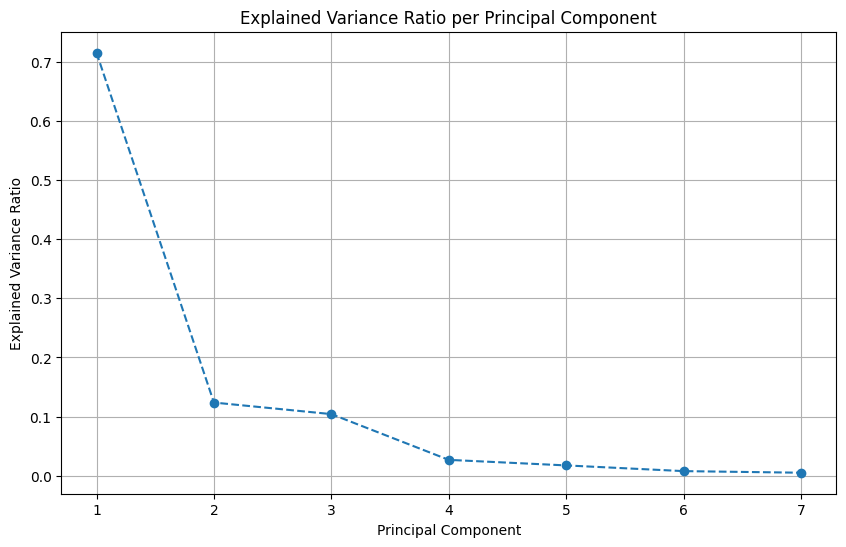

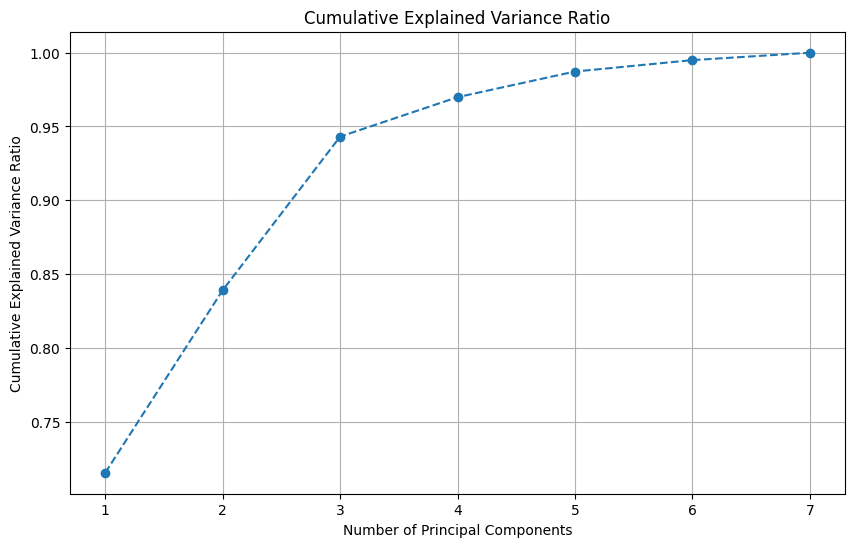

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_cp + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio per Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, n_cp + 1))
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_cp + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks(range(1, n_cp + 1))
plt.grid(True)
plt.show()

In [41]:
#matriz de loadings
pd.DataFrame(pca.components_, columns=variables_num)

mpg  cylinders  displacement  horsepower    weight  acceleration  \
0 -0.397776   0.416275      0.429530    0.422878  0.414151     -0.284842   
1  0.211681   0.190951      0.176884    0.091339  0.221398     -0.025000   
2 -0.255603   0.141389      0.104141   -0.167407  0.279876      0.892849   
3  0.741127   0.493587      0.297675   -0.060948 -0.113833      0.117826   
4  0.359822  -0.480799     -0.047998    0.710401  0.258803      0.234869   
5  0.211762  -0.331334      0.140362   -0.521410  0.698079     -0.222381   
6 -0.089713  -0.430910      0.814098   -0.067479 -0.365896      0.050610   

   model_year  
0   -0.229155  
1    0.910745  
2   -0.017200  
3   -0.296540  
4   -0.101216  
5   -0.130523  
6    0.050190

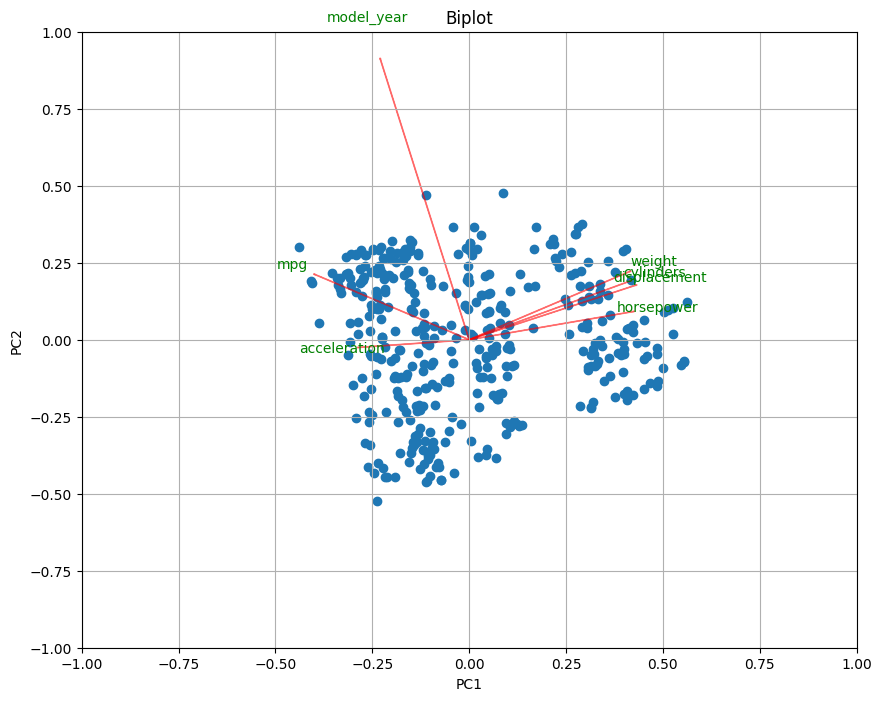

In [44]:
# Generate the biplot
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is not None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

plt.figure(figsize=(10, 8))
biplot(principalComponents[:,0:2], np.transpose(pca.components_[0:2, :]), labels=variables_num)
plt.title('Biplot')
plt.show()